# Contexte

Le service de cardiologie d'un hôpital doit analyser de nombreux signaux ECG enregistrant les battements cardiaques de leurs patients.  
Ils s'y intéressent pour détecter les crises cardiaques dans ces signaux. Celles-ci surviennent lorsqu'une ou plusieurs zones du muscle cardiaque ne reçoivent pas suffisamment d’oxygène. Cela se produit lorsque le flux sanguin vers le muscle cardiaque est bloqué. Alors que la crise cardiaque peut être détectée visuellement par l’homme.  
Il serait donc intéressant de mettre en place une méthode automatique capable de traiter des signaux beaucoup plus rapidement afin de prévenir les crises cardiaques, pour s'y préparer ou les éviter.  
Des signaux ECG étant disponibles, il peut être intéressant d'analyser ces données et d'utiliser des algorithmes de réseaux de neurones afin de distinguer les signaux ECG normaux et anormaux.

# 1. Collecte des données

In [1]:
%pip install codecarbon

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!curl -o "ECG200_train.tsv" https://maxime-devanne.com/datasets/ECG200/ECG200_TRAIN.tsv
!curl -o "ECG200_test.tsv" https://maxime-devanne.com/datasets/ECG200/ECG200_TEST.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 35  104k   35 37443    0     0  41093      0  0:00:02 --:--:--  0:00:02 41191
100  104k  100  104k    0     0   100k      0  0:00:01  0:00:01 --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  104k  100  104k    0     0   222k      0 --:--:-- --:--:-- --:--:--  224k


In [3]:
import pandas as pd

In [4]:
df_train = pd.read_csv('ECG200_train.tsv', sep='\t', header=None)
df_test = pd.read_csv('ECG200_test.tsv', sep='\t', header=None)

In [5]:
print(df_train.head(2))

   0         1         2         3         4         5         6         7   \
0  -1  0.502055  0.542163  0.722383  1.428885  2.136516  2.281149  1.936274   
1   1  0.147647  0.804668  0.367771  0.243894  0.026614 -0.274402  0.096731   

         8         9   ...        87        88        89        90        91  \
0  1.468890  1.008845  ...  0.931043  0.610298  0.638894  0.684679  0.583238   
1 -0.747731 -1.609777  ... -0.533503 -0.400228  0.176084  1.111768  2.438428   

         92        93        94        95        96  
0  0.640522  0.708585  0.705011  0.713815  0.433765  
1  2.734889  1.736054  0.036857 -1.265074 -0.208024  

[2 rows x 97 columns]


En jetant un oeil aux fichiers tsv, on remarque que chacun des fichiers possèdent 100 lignes, qui représentent 100 signaux différents.  
Le jeu de données présente 2 classes : signal normal et signal anormal.  
La 1ère colonne correspond à la classe du signal, caractérisée par un 1 ou un -1.  
Les autres colonnes représentent les différents points des signaux au fil du temps.

# 2. Analyse des données

In [6]:
import matplotlib.pyplot as plt

Distribution des classes dans le jeu d'entraînement 0
 1    69
-1    31
Name: count, dtype: int64
Distribution des classes dans le jeu de test 0
 1    64
-1    36
Name: count, dtype: int64


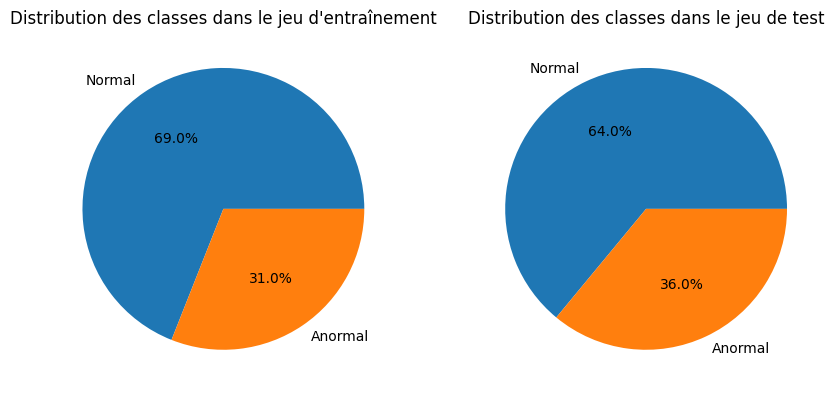

In [7]:
print("Distribution des classes dans le jeu d'entraînement", df_train[0].value_counts())
print("Distribution des classes dans le jeu de test", df_test[0].value_counts())
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(df_train[0].value_counts(), labels=['Normal', 'Anormal'], autopct='%1.1f%%')
plt.title("Distribution des classes dans le jeu d'entraînement")
plt.subplot(1, 2, 2)
plt.title("Distribution des classes dans le jeu de test")
plt.pie(df_test[0].value_counts(), labels=['Normal', 'Anormal'], autopct='%1.1f%%');

On remarque que le jeu de données est assez déséquilibré, il y a quasimment 2 fois plus de classes 1 que de classes -1.  
On peut alors supposer que la classe 1 correspond aux signaux normaux, et la classe 2 aux signaux anormaux, car il est plus facile d'obtenir des données de cas normaux que cas d'anromaux.  
Le déséquilibre des classes peut être embêtant dans la mesure où le modèle aura un un échantillon de données où une classe sera sur-representée, et l'autre sous-représentée.  
Cela pourra possiblement poser soucis lors de l'entraînement.

Les fichiers au format tsv contiennent les données numériques des signaux ECG, on peut plot ces données pour savoir à quoi ressemblent les signaux normaux et anormaux.

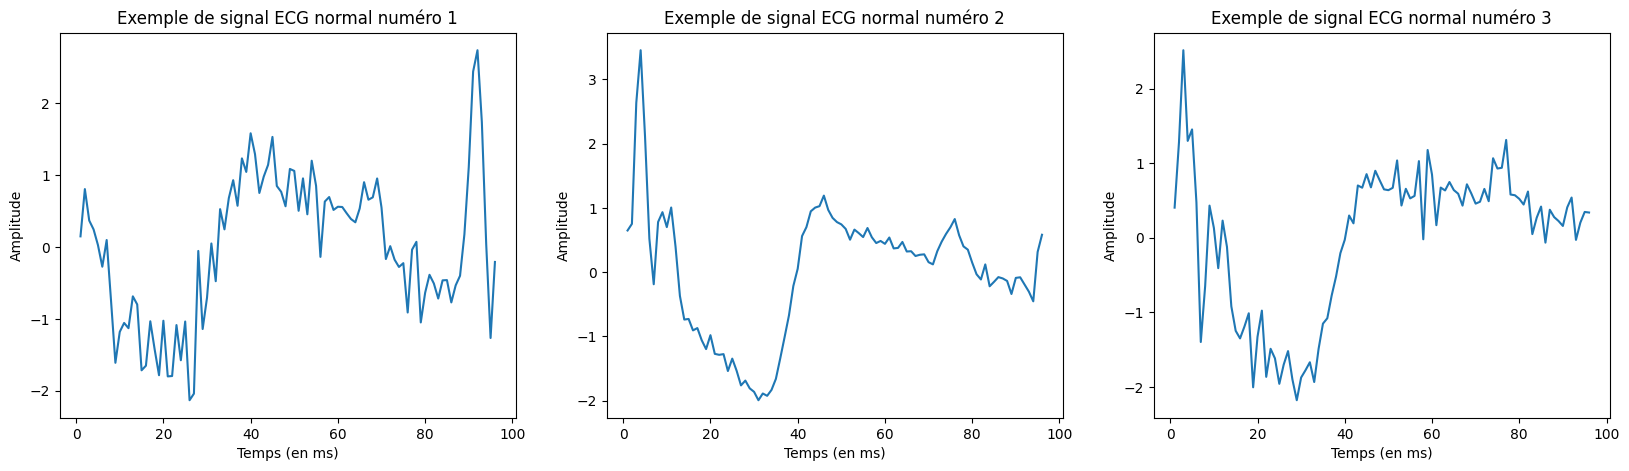

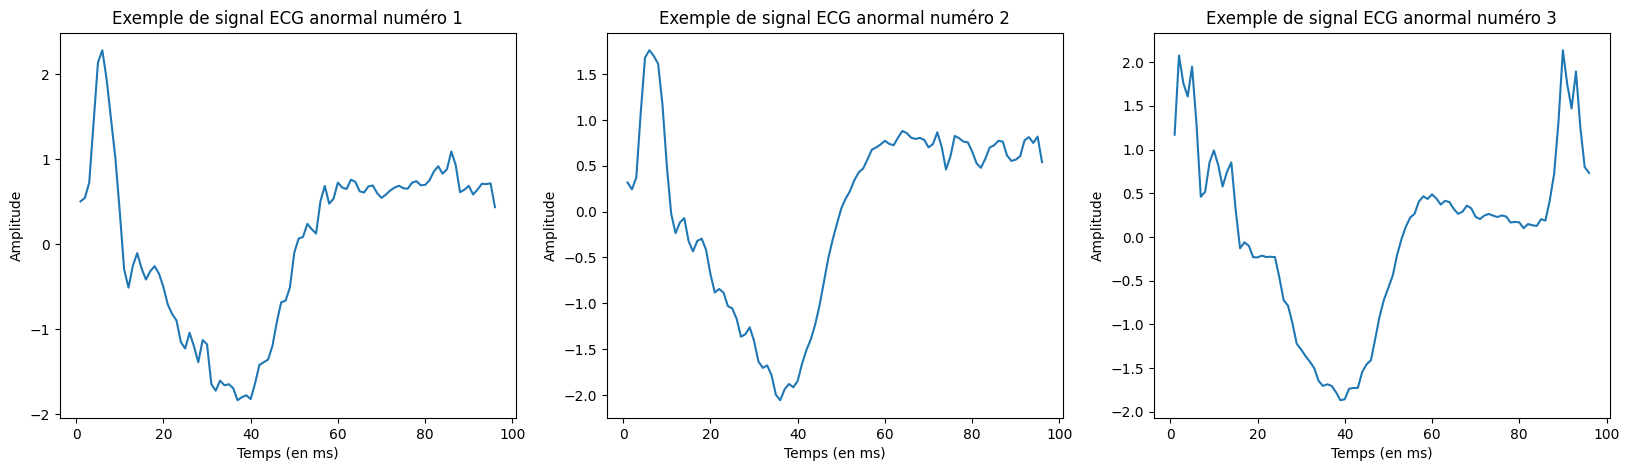

In [8]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(df_train[df_train[0] == 1].iloc[i, 1:]) # on ne prend pas en compte la colonne de classe
    plt.xlabel("Temps (en ms)")
    plt.ylabel("Amplitude")
    plt.title("Exemple de signal ECG normal numéro " + str(i+1))

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlabel("Temps (en ms)")
    plt.ylabel("Amplitude")
    plt.plot(df_train[df_train[0] == -1].iloc[i, 1:])
    plt.title("Exemple de signal ECG anormal numéro " + str(i+1))
    

# 3. Transformation des données

In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical

On crée nos ensembles d'entrainements, puis on transforme les labels en one-hot.

In [10]:
X_train_original = df_train.iloc[:, 1:].values
y_train_original = df_train.iloc[:, 0].values
X_test_original = df_test.iloc[:, 1:].values
y_test_original = df_test.iloc[:, 0].values

In [11]:
y_train = np.where(y_train_original==-1, 0, 1) # la fonction to_categorical ne fonctionne pas avec les classes négatives
y_train = to_categorical(y_train, num_classes=2)
y_test = np.where(y_test_original==-1, 0, 1)
y_test = to_categorical(y_test, num_classes=2)

print("On vérifie que les données sont bien dans le bon format\n", y_train[:5])

On vérifie que les données sont bien dans le bon format
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [12]:
print("Valeur maximale dans le jeu d'entraînement", X_train_original.max())
print("Valeur minimale dans le jeu d'entraînement", X_test_original.min())

Valeur maximale dans le jeu d'entraînement 4.1991449
Valeur minimale dans le jeu d'entraînement -3.0144511


Et on normalise les données en utilisant minmax

In [13]:
X_train = (X_train_original - X_train_original.min()) / (X_train_original.max() - X_train_original.min())
X_test = (X_test_original - X_test_original.min()) / (X_test_original.max() - X_test_original.min())

print("Valeur maximale dans le jeu d'entraînement normalisé", X_train.max())
print("Valeur minimale dans le jeu d'entraînement normalisé", X_test.min())

Valeur maximale dans le jeu d'entraînement normalisé 1.0
Valeur minimale dans le jeu d'entraînement normalisé 0.0


# 4. Choisir et entraîner les modèles

Les données sont maintenant prêtes à être utilisées dans nos modèles.  
Différents modèles seront utilisés, on garde en mémoire chaque modèle et leurs entraînements.

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

## 4.1. MLP

On crée un premier réseau de perceptrons multicouche assez "simple", ne contenant qu'une couche cachée de 32 neurones.

In [15]:
input_shape = X_train.shape[1]
input = layers.Input(shape=(input_shape,))
x = layers.Dense(32, activation='relu')(input)
output = layers.Dense(2, activation='softmax')(x)
mlp_model1 = models.Model(input, output)

In [16]:
mlp_model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,170 (12.38 KB)

 Trainable params: 3,170 (12.38 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
mlp_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

On ne choisit que 150 epochs car l'échantillon de données n'est pas énorme et on ne souhaite pas que le modèle suraprenne.  
On choisit de surveiller le F1-Score plutôt que l'accuracy car le jeu de données est déséquilibré et que l'accuracy n'est alors plus pertinente. Des explications sont dans la partie "Évaluation des modèles"

In [18]:
import codecarbon
from codecarbon import EmissionsTracker

In [19]:
epochs = 150
batch_size = 32
percentage_as_validation = 0.2

In [20]:
tracker = EmissionsTracker(project_name="mlp_model1")
tracker.start()

[codecarbon INFO @ 22:42:58] [setup] RAM Tracking...
[codecarbon INFO @ 22:42:58] [setup] GPU Tracking...
[codecarbon INFO @ 22:42:58] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:42:58] [setup] CPU Tracking...
[codecarbon WARNING @ 22:42:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:43:00] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:43:00] >>> Tracker's metadata:
[codecarbon INFO @ 22:43:00]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:43:00]   Python version: 3.10.6
[codecarbon INFO @ 22:43:00]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:43:00]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:43:00]   CPU count: 16
[codecarbon INFO @ 22:43:00]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:43:00]   GPU count: 1
[codecarbon INFO @ 22:43:00]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


In [21]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('models/best_mlp1.keras', monitor='val_loss', save_best_only=True)
mlp_history = mlp_model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=percentage_as_validation, callbacks=[model_checkpoint])

Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.4141 - f1_score: 0.3897 - loss: 0.7021 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6947
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6945 - f1_score: 0.4097 - loss: 0.6109 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.7163
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7727 - f1_score: 0.4352 - loss: 0.5366 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.7590
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7297 - f1_score: 0.4218 - loss: 0.5576 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.7723
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7453 - f1_score: 0.4269 - loss: 0.5336 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.7669
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7297 - f1_score: 0.4218 - loss: 0.5473 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss

[codecarbon INFO @ 22:43:16] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.945822238922119 W
[codecarbon INFO @ 22:43:16] Energy consumed for all GPUs : 0.000062 kWh. Total GPU Power : 14.945288809349993 W
[codecarbon INFO @ 22:43:16] Energy consumed for all CPUs : 0.000113 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:43:16] 0.000200 kWh of electricity used since the beginning.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8734 - f1_score: 0.8301 - loss: 0.2581 - val_accuracy: 0.7000 - val_f1_score: 0.6875 - val_loss: 0.5581
Epoch 115/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8969 - f1_score: 0.8768 - loss: 0.2428 - val_accuracy: 0.7000 - val_f1_score: 0.6875 - val_loss: 0.5718
Epoch 116/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9008 - f1_score: 0.8715 - loss: 0.2247 - val_accuracy: 0.7000 - val_f1_score: 0.6875 - val_loss: 0.5991
Epoch 117/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8508 - f1_score: 0.8072 - loss: 0.2558 - val_accuracy: 0.7000 - val_f1_score: 0.6875 - val_loss: 0.6138
Epoch 118/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8844 - f1_score: 0.8510 - loss: 0.2344 - val_accuracy: 0.7000 - val_f1_score: 0.6875 - val_loss: 0.5974
Epoch 119/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8828 - f1_score: 0.8576 - loss: 0.2432 - val_accuracy: 0.7000 - val_f1_score: 0.6875 - val_loss: 0

In [22]:
emissions_mlp1 : float = tracker.stop()

[codecarbon INFO @ 22:43:20] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.945822238922119 W
[codecarbon INFO @ 22:43:20] Energy consumed for all GPUs : 0.000080 kWh. Total GPU Power : 14.926573307668548 W
[codecarbon INFO @ 22:43:20] Energy consumed for all CPUs : 0.000144 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:43:20] 0.000255 kWh of electricity used since the beginning.
c:\Users\LINPa\AppData\Local\Programs\Python\Python310\lib\site-packages\codecarbon\output.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])


In [23]:
def plot_history(history, metric):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric], label='Train ' + metric )
    plt.plot(history.history['val_'+metric], label='Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.title(metric)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

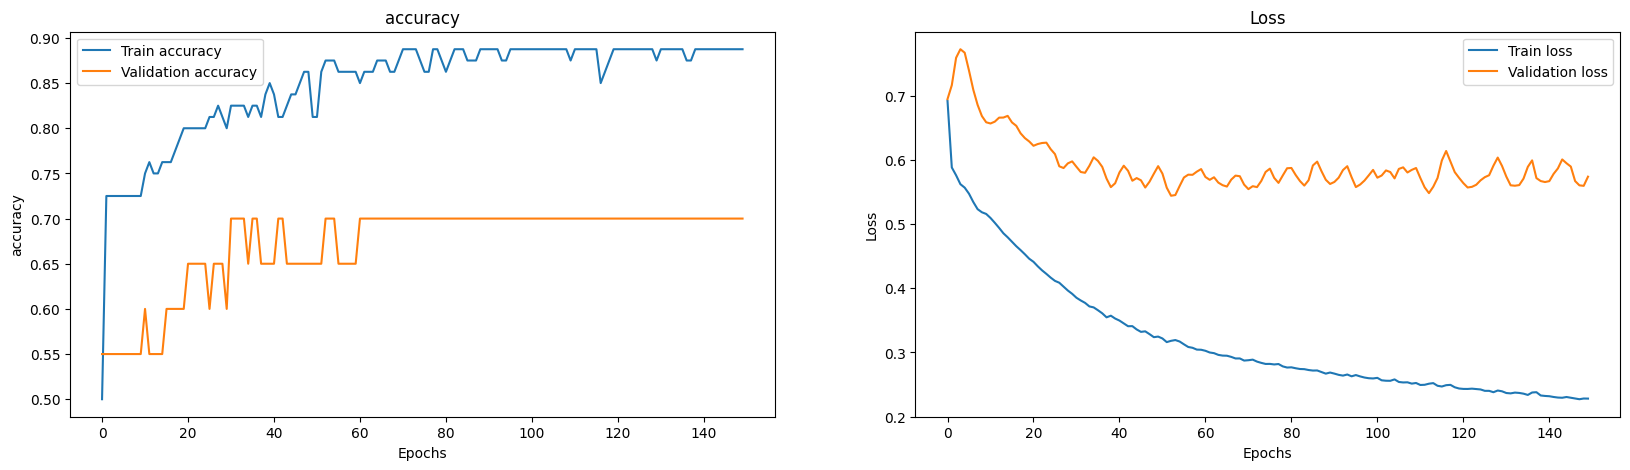

In [24]:
plot_history(mlp_history, "accuracy")

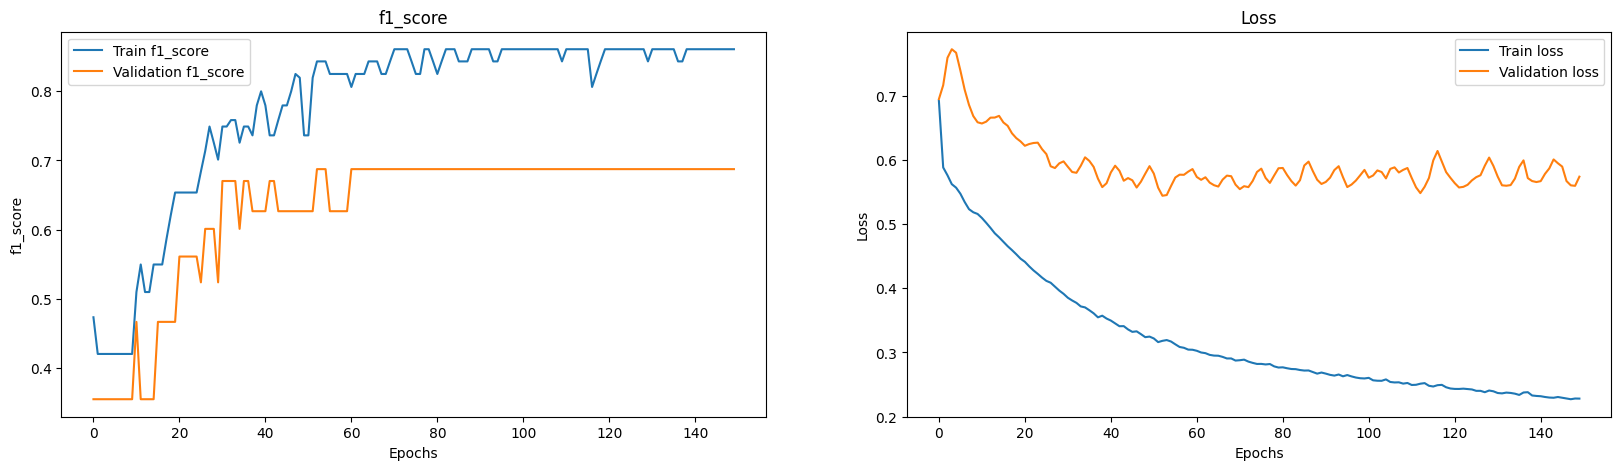

In [25]:
plot_history(mlp_history, "f1_score")

L'accuracy est en effet plus élevée que le F1-Score, mais cela est dû au déséquilibre des classes.  
De plus, le modèle ne surparrend pas forcément, mais a du mal à généraliseR.

On crée une fonction pour permettre d'entraîner les modèles plus facilement.

In [26]:
def train_model(model, model_name, X_train, y_train):
    epochs = 150
    batch_size = 32
    percentage_as_validation = 0.2
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])
    tracker = EmissionsTracker(project_name=model_name)
    tracker.start()
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint('models/'+model_name+'.keras', monitor='val_loss', save_best_only=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=percentage_as_validation, callbacks=[model_checkpoint], verbose=False)
    emissions : float = tracker.stop()
    plot_history(mlp_history, "accuracy")
    plot_history(mlp_history, "f1_score")
    return model, history

On ajoute plus de couches au MLP pour voir ce qui peut en sortir ainsi que des couches de régularisation pour essayer d'éviter un surparentissage et aider à la généralisation.

In [27]:
input_shape = X_train.shape[1]
input = layers.Input(shape=(input_shape,))
x = layers.Dense(64, activation='relu')(input)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x= layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
mlp_model2 = models.Model(input, output)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,138 (106.01 KB)

 Trainable params: 27,138 (106.01 KB)

 Non-trainable params: 0 (0.00 B)

[codecarbon INFO @ 22:43:21] [setup] RAM Tracking...
[codecarbon INFO @ 22:43:21] [setup] GPU Tracking...
[codecarbon INFO @ 22:43:21] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:43:21] [setup] CPU Tracking...
[codecarbon WARNING @ 22:43:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:43:23] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:43:23] >>> Tracker's metadata:
[codecarbon INFO @ 22:43:23]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:43:23]   Python version: 3.10.6
[codecarbon INFO @ 22:43:23]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:43:23]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:43:23]   CPU count: 16
[codecarbon INFO @ 22:43:23]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:43:23]   GPU count: 1
[codecarbon INFO @ 22:43:23]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU
[codecarbon INFO @ 22:43:38] Ene

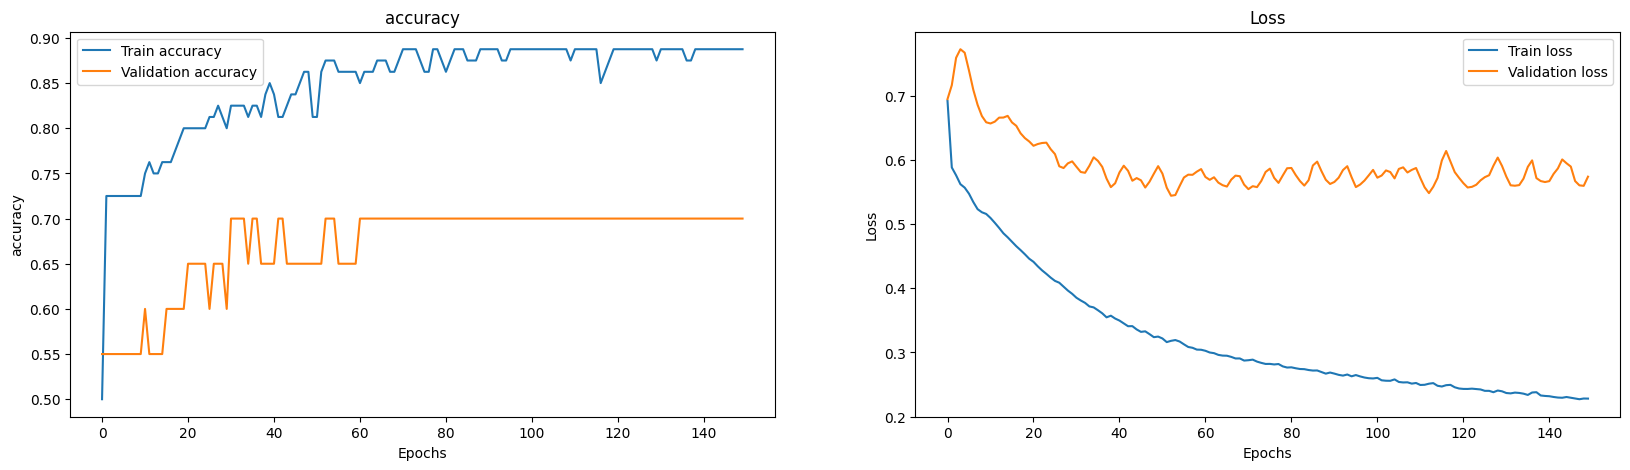

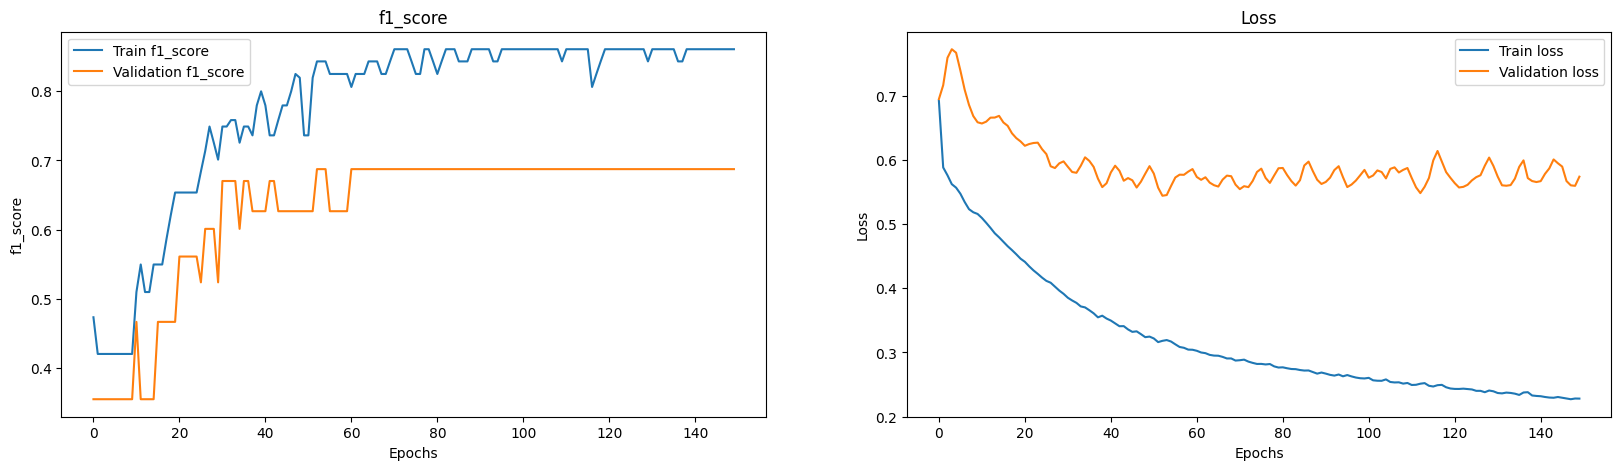

In [28]:
mlp_model2, mlp2_history = train_model(mlp_model2, "mlp_model2", X_train, y_train)

Le modèle n'a pas l'air meilleur que le précédent et on observe de fortes oscillations qui sont peut-être dues au learning rate ou à la faible taille du jeu de données. On peut essayer de changer le learning rate.

Avec un learning rate de 0.01 ?

In [29]:
input_shape = X_train.shape[1]
input = layers.Input(shape=(input_shape,))
x = layers.Dense(64, activation='relu')(input)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x= layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
mlp_model_test = models.Model(input, output)

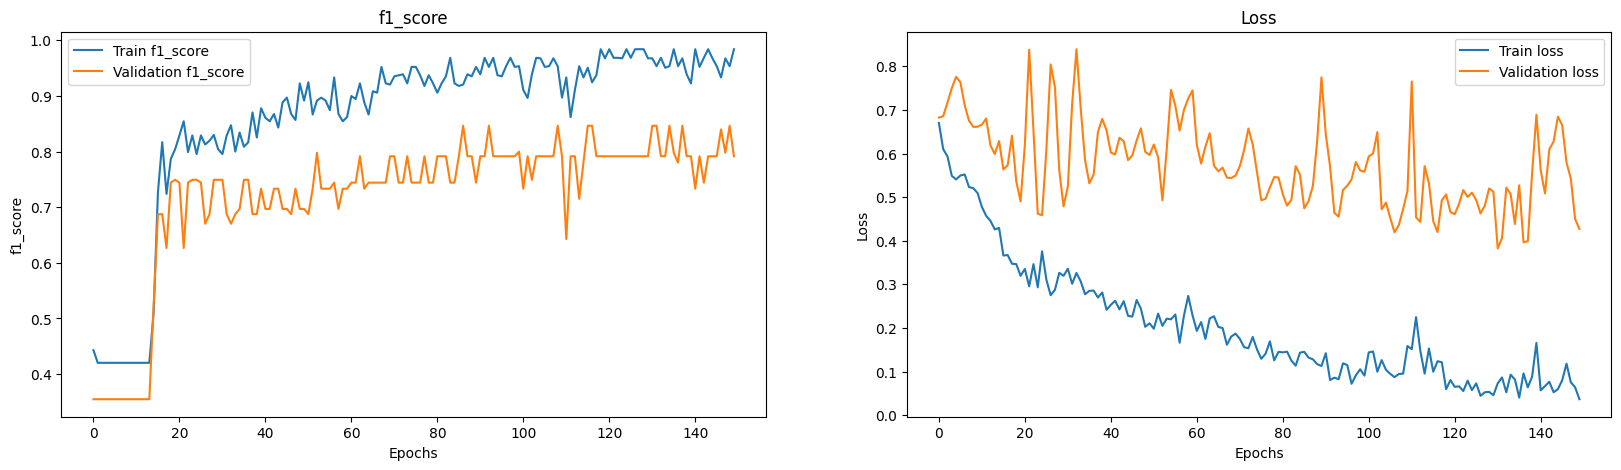

In [30]:
plot_history(mlp2_history, "f1_score")

In [31]:
mlp_model_test.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy',metrics=["accuracy", tf.keras.metrics.F1Score(average='macro')])

In [32]:
tracker = EmissionsTracker(project_name="mlp_model_test")
tracker.start()

[codecarbon INFO @ 22:43:44] [setup] RAM Tracking...
[codecarbon INFO @ 22:43:44] [setup] GPU Tracking...
[codecarbon INFO @ 22:43:44] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:43:44] [setup] CPU Tracking...
[codecarbon WARNING @ 22:43:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:43:46] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:43:46] >>> Tracker's metadata:
[codecarbon INFO @ 22:43:46]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:43:46]   Python version: 3.10.6
[codecarbon INFO @ 22:43:46]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:43:46]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:43:46]   CPU count: 16
[codecarbon INFO @ 22:43:46]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:43:46]   GPU count: 1
[codecarbon INFO @ 22:43:46]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


In [33]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('models/best_mlp_test.keras', monitor='val_loss', save_best_only=True)
mlp_test_history = mlp_model_test.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=percentage_as_validation, callbacks=[model_checkpoint])

Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.5805 - f1_score: 0.4870 - loss: 0.7312 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.8605
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7180 - f1_score: 0.4179 - loss: 0.6214 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6875
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7375 - f1_score: 0.4243 - loss: 0.6275 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.7431
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7063 - f1_score: 0.4137 - loss: 0.5914 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.8468
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7180 - f1_score: 0.4179 - loss: 0.6112 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6868
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7375 - f1_score: 0.4243 - loss: 0.5396 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss

[codecarbon INFO @ 22:44:01] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.945822238922119 W
[codecarbon INFO @ 22:44:01] Energy consumed for all GPUs : 0.000064 kWh. Total GPU Power : 15.358955348911502 W
[codecarbon INFO @ 22:44:01] Energy consumed for all CPUs : 0.000113 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:44:01] 0.000202 kWh of electricity used since the beginning.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8828 - f1_score: 0.8618 - loss: 0.1683 - val_accuracy: 0.6500 - val_f1_score: 0.6491 - val_loss: 0.3724
Epoch 96/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9375 - f1_score: 0.9195 - loss: 0.1567 - val_accuracy: 0.7500 - val_f1_score: 0.7333 - val_loss: 0.4731
Epoch 97/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9031 - f1_score: 0.8621 - loss: 0.1634 - val_accuracy: 0.7500 - val_f1_score: 0.7333 - val_loss: 0.4007
Epoch 98/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9273 - f1_score: 0.9081 - loss: 0.1590 - val_accuracy: 0.7500 - val_f1_score: 0.7333 - val_loss: 0.5354
Epoch 99/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8977 - f1_score: 0.8592 - loss: 0.1722 - val_accuracy: 0.8000 - val_f1_score: 0.7802 - val_loss: 0.9034
Epoch 100/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9133 - f1_score: 0.8825 - loss: 0.1527 - val_accuracy: 0.7000 - val_f1_score: 0.7000 - val_loss: 0.632

In [34]:
emissions_mlp2 : float = tracker.stop()

[codecarbon INFO @ 22:44:07] Energy consumed for RAM : 0.000035 kWh. RAM Power : 5.945822238922119 W
[codecarbon INFO @ 22:44:07] Energy consumed for all GPUs : 0.000091 kWh. Total GPU Power : 15.816786559313133 W
[codecarbon INFO @ 22:44:07] Energy consumed for all CPUs : 0.000159 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:44:07] 0.000285 kWh of electricity used since the beginning.


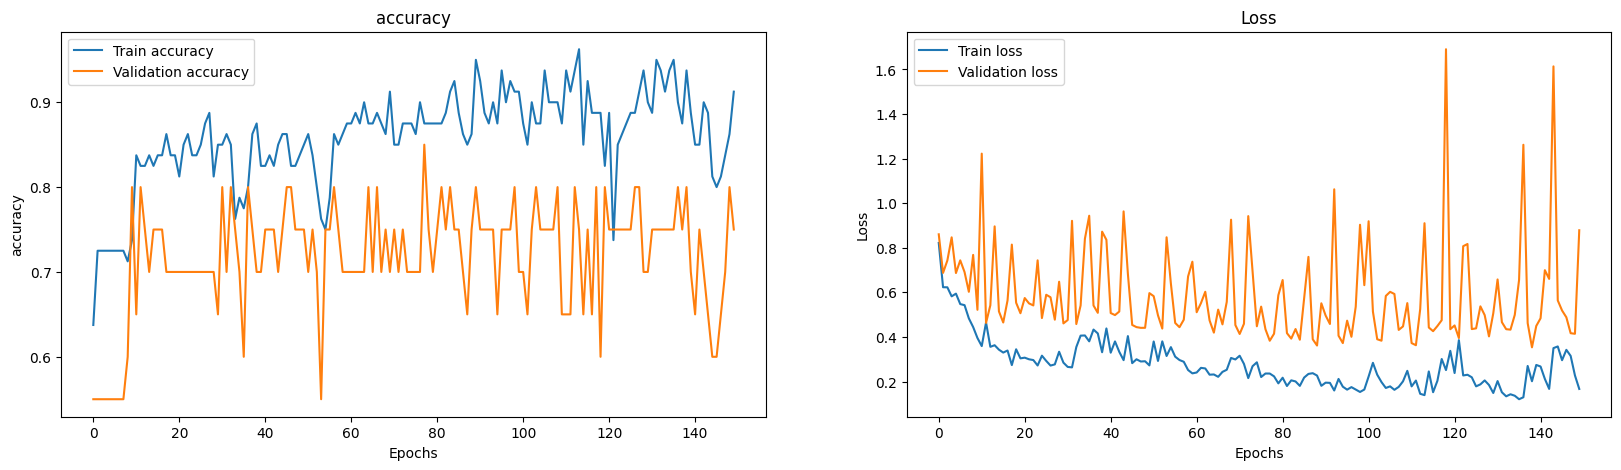

In [35]:
plot_history(mlp_test_history, "accuracy")

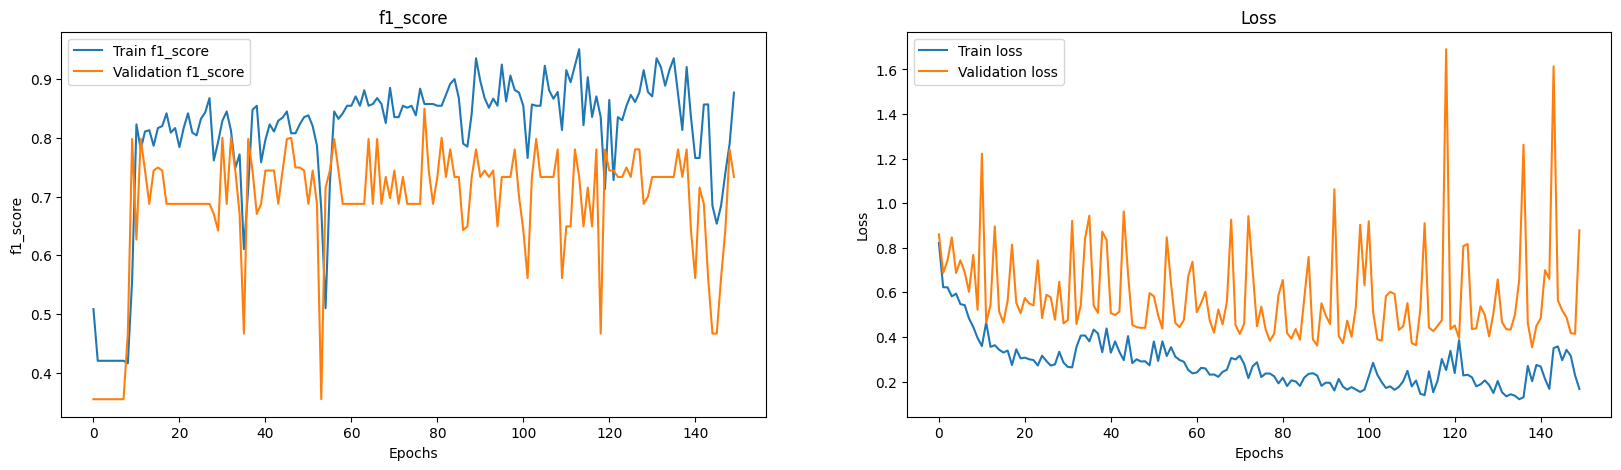

In [36]:
plot_history(mlp_test_history, "f1_score")

Avec un learning rate de 0.0001 ?

In [37]:
input_shape = X_train.shape[1]
input = layers.Input(shape=(input_shape,))
x = layers.Dense(64, activation='relu')(input)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x= layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
mlp_model_test = models.Model(input, output)

In [38]:
mlp_model_test.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=["accuracy", tf.keras.metrics.F1Score(average='macro')])

In [39]:
tracker = EmissionsTracker(project_name="mlp_model_test")
tracker.start()

[codecarbon INFO @ 22:44:09] [setup] RAM Tracking...


[codecarbon INFO @ 22:44:09] [setup] GPU Tracking...
[codecarbon INFO @ 22:44:09] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:44:09] [setup] CPU Tracking...
[codecarbon WARNING @ 22:44:09] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:44:10] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:44:10] >>> Tracker's metadata:
[codecarbon INFO @ 22:44:10]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:44:10]   Python version: 3.10.6
[codecarbon INFO @ 22:44:10]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:44:10]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:44:10]   CPU count: 16
[codecarbon INFO @ 22:44:10]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:44:10]   GPU count: 1
[codecarbon INFO @ 22:44:10]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


In [40]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('models/best_mlp_test.keras', monitor='val_loss', save_best_only=True)
mlp_test_history = mlp_model_test.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=percentage_as_validation, callbacks=[model_checkpoint])

Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.2930 - f1_score: 0.2655 - loss: 0.7137 - val_accuracy: 0.4500 - val_f1_score: 0.3732 - val_loss: 0.7029
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2766 - f1_score: 0.2758 - loss: 0.7069 - val_accuracy: 0.3000 - val_f1_score: 0.2929 - val_loss: 0.6994
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4336 - f1_score: 0.4137 - loss: 0.6989 - val_accuracy: 0.4500 - val_f1_score: 0.3732 - val_loss: 0.6966
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4695 - f1_score: 0.3491 - loss: 0.6948 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6947
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6711 - f1_score: 0.4712 - loss: 0.6843 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6933
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7117 - f1_score: 0.4990 - loss: 0.6780 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss

[codecarbon INFO @ 22:44:26] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.945822238922119 W
[codecarbon INFO @ 22:44:26] Energy consumed for all GPUs : 0.000058 kWh. Total GPU Power : 13.879520600622806 W
[codecarbon INFO @ 22:44:26] Energy consumed for all CPUs : 0.000113 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:44:26] 0.000196 kWh of electricity used since the beginning.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8188 - f1_score: 0.7020 - loss: 0.3921 - val_accuracy: 0.6500 - val_f1_score: 0.6267 - val_loss: 0.5648
Epoch 88/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8664 - f1_score: 0.8151 - loss: 0.3764 - val_accuracy: 0.7000 - val_f1_score: 0.6703 - val_loss: 0.5690
Epoch 89/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8125 - f1_score: 0.7113 - loss: 0.3936 - val_accuracy: 0.7000 - val_f1_score: 0.6703 - val_loss: 0.5724
Epoch 90/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8328 - f1_score: 0.7642 - loss: 0.3833 - val_accuracy: 0.6500 - val_f1_score: 0.6267 - val_loss: 0.5734
Epoch 91/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8406 - f1_score: 0.7348 - loss: 0.3718 - val_accuracy: 0.6500 - val_f1_score: 0.6267 - val_loss: 0.5751
Epoch 92/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8109 - f1_score: 0.7102 - loss: 0.3576 - val_accuracy: 0.7000 - val_f1_score: 0.6875 - val_loss: 0.5707

In [41]:
emissions_mlp2 : float = tracker.stop()

[codecarbon INFO @ 22:44:33] Energy consumed for RAM : 0.000036 kWh. RAM Power : 5.945822238922119 W


[codecarbon INFO @ 22:44:33] Energy consumed for all GPUs : 0.000088 kWh. Total GPU Power : 15.18990118991832 W
[codecarbon INFO @ 22:44:33] Energy consumed for all CPUs : 0.000166 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:44:33] 0.000290 kWh of electricity used since the beginning.


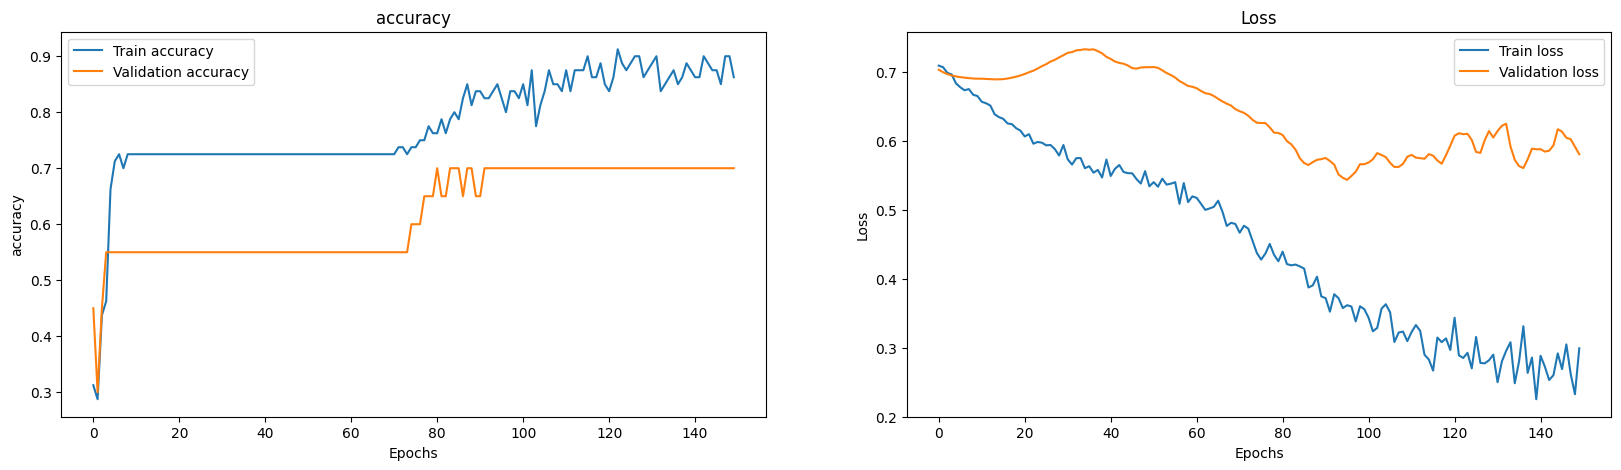

In [42]:
plot_history(mlp_test_history, "accuracy")

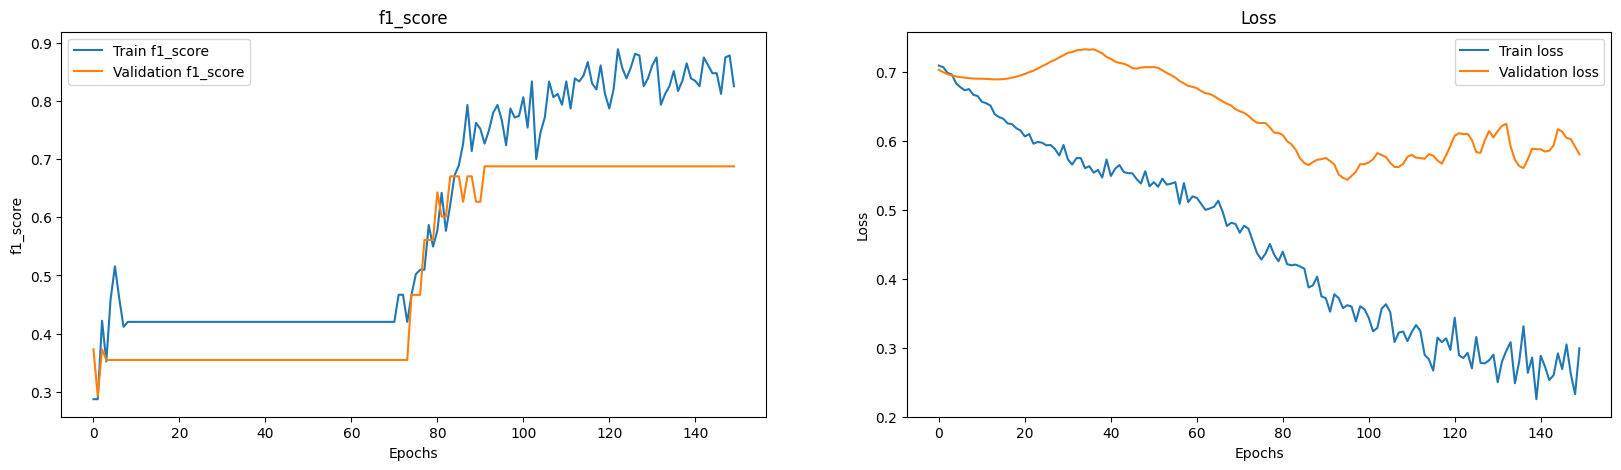

In [43]:
plot_history(mlp_test_history, "f1_score")

Avec un learning rate de 0.00001? 

In [44]:
input_shape = X_train.shape[1]
input = layers.Input(shape=(input_shape,))
x = layers.Dense(64, activation='relu')(input)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x= layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
mlp_model_test = models.Model(input, output)

In [45]:
mlp_model_test.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy',metrics=["accuracy", tf.keras.metrics.F1Score(average='macro')])

In [46]:
tracker = EmissionsTracker(project_name="mlp_model_test")
tracker.start()

[codecarbon INFO @ 22:44:34] [setup] RAM Tracking...
[codecarbon INFO @ 22:44:34] [setup] GPU Tracking...
[codecarbon INFO @ 22:44:34] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:44:34] [setup] CPU Tracking...
[codecarbon WARNING @ 22:44:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:44:36] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:44:36] >>> Tracker's metadata:
[codecarbon INFO @ 22:44:36]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:44:36]   Python version: 3.10.6
[codecarbon INFO @ 22:44:36]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:44:36]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:44:36]   CPU count: 16
[codecarbon INFO @ 22:44:36]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:44:36]   GPU count: 1
[codecarbon INFO @ 22:44:36]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


In [47]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('models/best_mlp_test.keras', monitor='val_loss', save_best_only=True)
mlp_test_history = mlp_model_test.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=percentage_as_validation, callbacks=[model_checkpoint])

Epoch 1/150


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.7180 - f1_score: 0.4179 - loss: 0.6643 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6889
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6938 - f1_score: 0.4096 - loss: 0.6636 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6888
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7320 - f1_score: 0.4786 - loss: 0.6572 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6888
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7375 - f1_score: 0.4244 - loss: 0.6584 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6888
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7156 - f1_score: 0.4170 - loss: 0.6619 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6888
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7180 - f1_score: 0.4179 - loss: 0.6574 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6888
Epo

[codecarbon INFO @ 22:44:52] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.945822238922119 W
[codecarbon INFO @ 22:44:52] Energy consumed for all GPUs : 0.000063 kWh. Total GPU Power : 14.967976404534856 W
[codecarbon INFO @ 22:44:52] Energy consumed for all CPUs : 0.000113 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:44:52] 0.000200 kWh of electricity used since the beginning.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7727 - f1_score: 0.4352 - loss: 0.5903 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6957
Epoch 95/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6984 - f1_score: 0.4108 - loss: 0.6314 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6958
Epoch 96/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7492 - f1_score: 0.4282 - loss: 0.6006 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6959
Epoch 97/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7141 - f1_score: 0.4163 - loss: 0.6214 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6960
Epoch 98/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7219 - f1_score: 0.4192 - loss: 0.6097 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6961
Epoch 99/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7180 - f1_score: 0.4179 - loss: 0.6238 - val_accuracy: 0.5500 - val_f1_score: 0.3548 - val_loss: 0.6963

In [48]:
emissions_mlp2 : float = tracker.stop()

[codecarbon INFO @ 22:44:58] Energy consumed for RAM : 0.000035 kWh. RAM Power : 5.945822238922119 W
[codecarbon INFO @ 22:44:58] Energy consumed for all GPUs : 0.000091 kWh. Total GPU Power : 16.075707311134458 W


[codecarbon INFO @ 22:44:58] Energy consumed for all CPUs : 0.000161 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:44:58] 0.000287 kWh of electricity used since the beginning.


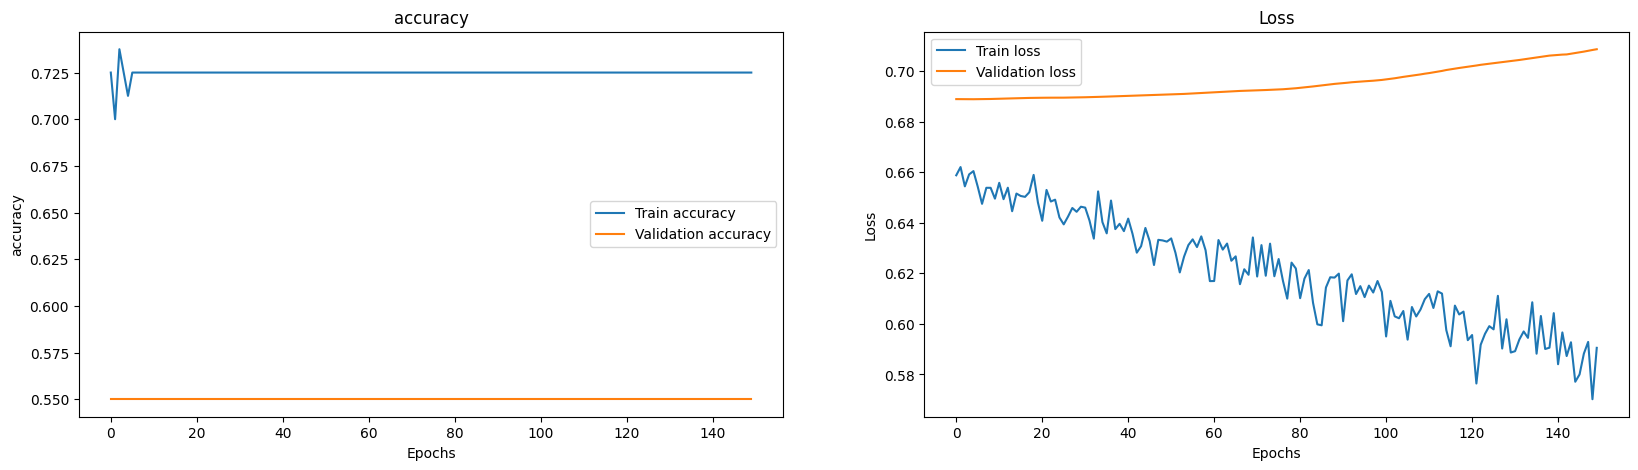

In [49]:
plot_history(mlp_test_history, "accuracy")

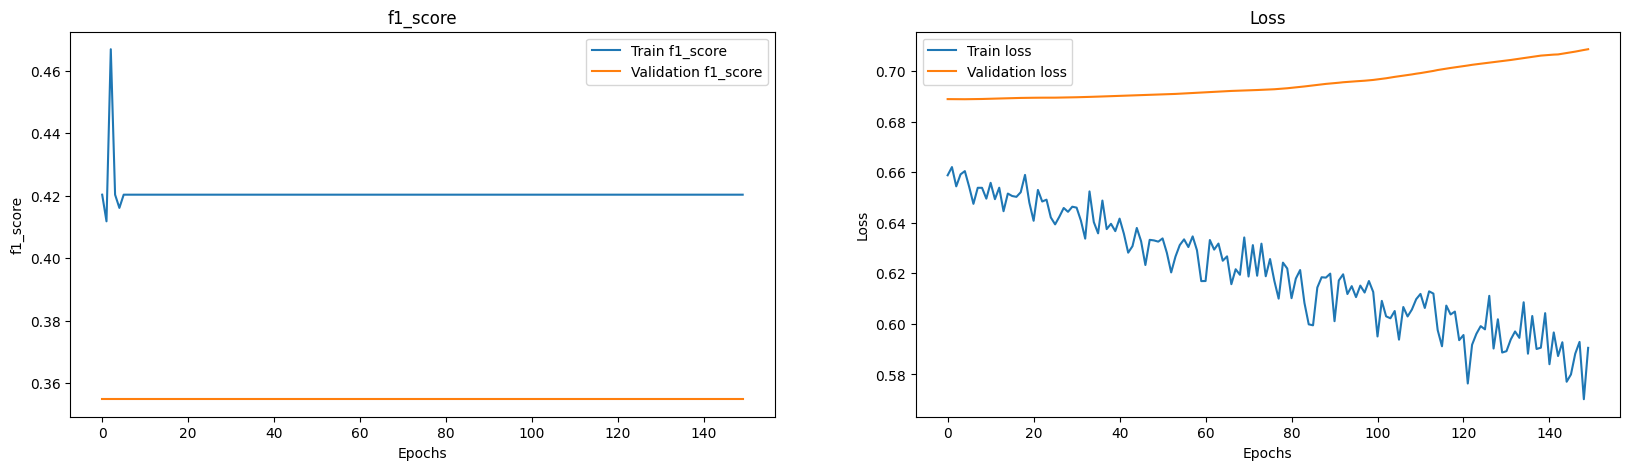

In [50]:
plot_history(mlp_test_history, "f1_score")

Au vu de ces tests, nous allons garder un learning rate par défaut de 0.001.

Cette fois, on multiplie le nombre de neurones à chaque couches

In [51]:
input_shape = X_train.shape[1]
input = layers.Input(shape=(input_shape,))
x = layers.Dense(256, activation='relu')(input)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x= layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
mlp_model3 = models.Model(input, output)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,416 (318.04 KB)

 Trainable params: 27,138 (106.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54,278 (212.03 KB)

[codecarbon INFO @ 22:45:00] [setup] RAM Tracking...
[codecarbon INFO @ 22:45:00] [setup] GPU Tracking...
[codecarbon INFO @ 22:45:00] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:45:00] [setup] CPU Tracking...
[codecarbon WARNING @ 22:45:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:45:01] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:45:01] >>> Tracker's metadata:
[codecarbon INFO @ 22:45:01]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:45:01]   Python version: 3.10.6
[codecarbon INFO @ 22:45:01]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:45:01]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:45:01]   CPU count: 16
[codecarbon INFO @ 22:45:01]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:45:01]   GPU count: 1
[codecarbon INFO @ 22:45:01]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU
[codecarbon WARNING @ 22:45:02] 

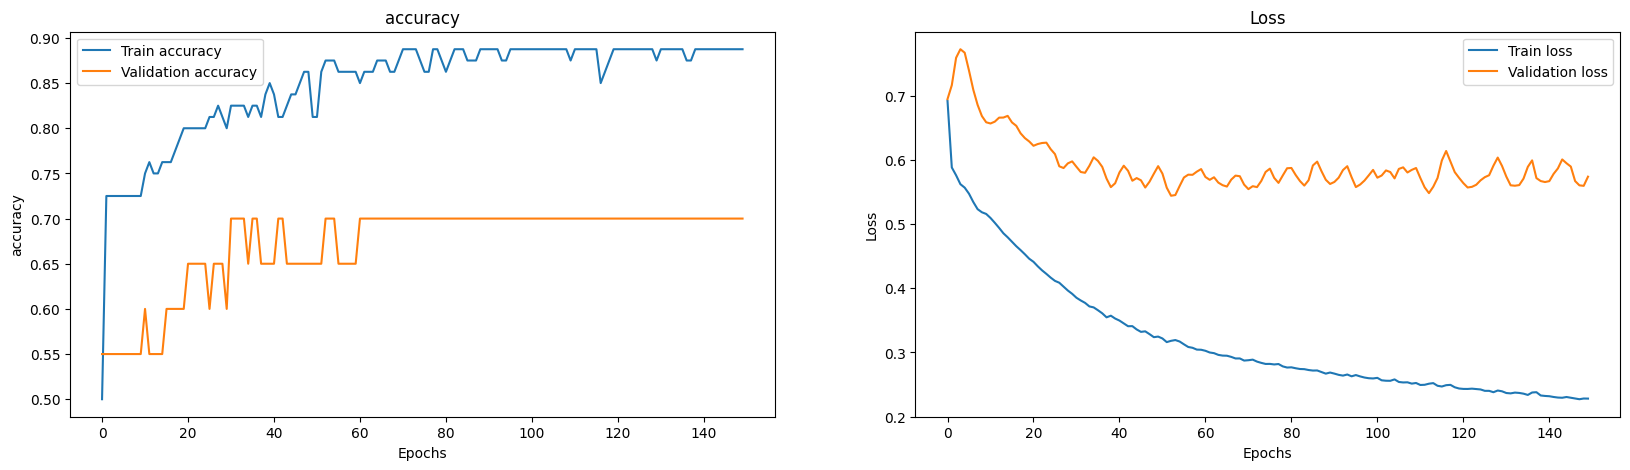

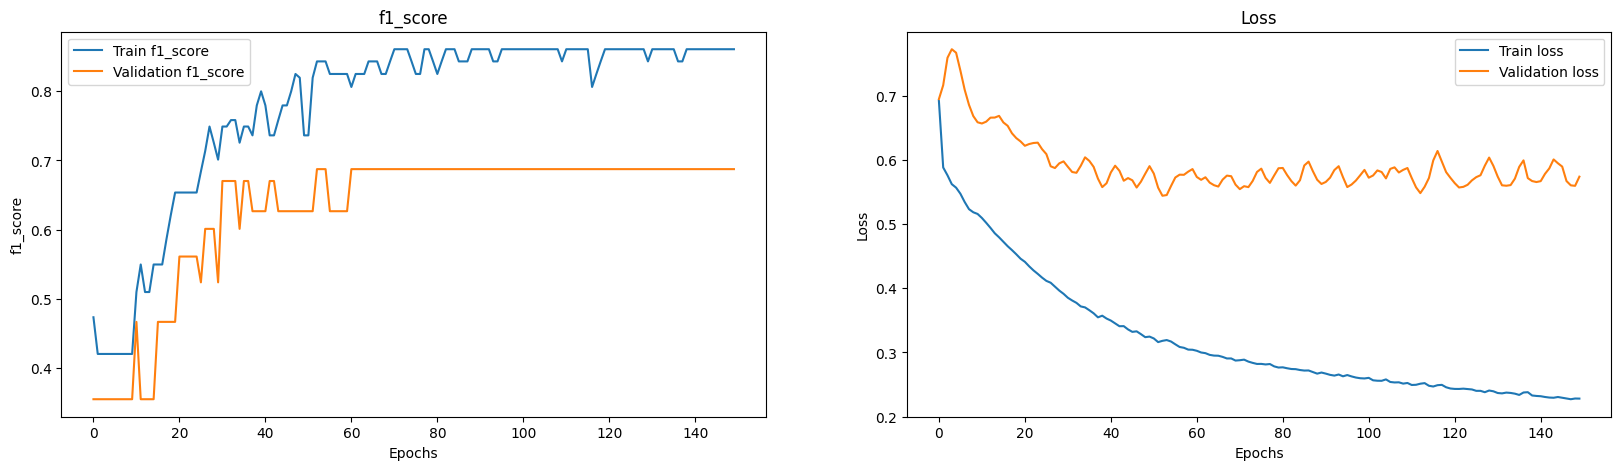

In [52]:
mlp_model3, mlp3_history = train_model(mlp_model2, "mlp_model3", X_train, y_train)

L'architecture du modèle joue un rôle crucial dans la performance du modèle.  
Une architecture trop simple n'arrivera pas à généraliser et présentera une précision plus faible, tandis qu'une architecture plus complexe arrivera à reconnaître des détails plus fins, mais aura tendance à plus surapprendre.  
De plus, il ne faut pas oublier que les classes sont déséquilibrées. La métrique de précision n'est alors pas la plus fiable.

# 4.2 CNN

Pour utiliser un CNN, on va considérer notre série temporelle comme une "image" en 1D

In [53]:
X_train_CNN = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_CNN = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print("Shape des données d'entraînement", X_train_CNN.shape)

Shape des données d'entraînement (100, 96, 1)


In [56]:
input_shape = X_train_CNN.shape[1:]
input = layers.Input(shape=(input_shape))
x = layers.Conv1D(8, 3, padding="same", activation='relu')(input) #on utilise padding="same" pour ne pas perdre d'informations 
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
cnn_model1 = models.Model(input, output)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 8)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,834 (97.01 KB)

 Trainable params: 24,818 (96.95 KB)

 Non-trainable params: 16 (64.00 B)

[codecarbon INFO @ 22:45:40] [setup] RAM Tracking...
[codecarbon INFO @ 22:45:40] [setup] GPU Tracking...
[codecarbon INFO @ 22:45:40] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:45:40] [setup] CPU Tracking...
[codecarbon WARNING @ 22:45:40] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:45:42] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:45:42] >>> Tracker's metadata:
[codecarbon INFO @ 22:45:42]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:45:42]   Python version: 3.10.6
[codecarbon INFO @ 22:45:42]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:45:42]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:45:42]   CPU count: 16
[codecarbon INFO @ 22:45:42]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:45:42]   GPU count: 1
[codecarbon INFO @ 22:45:42]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU
[codecarbon INFO @ 22:45:57] Ene

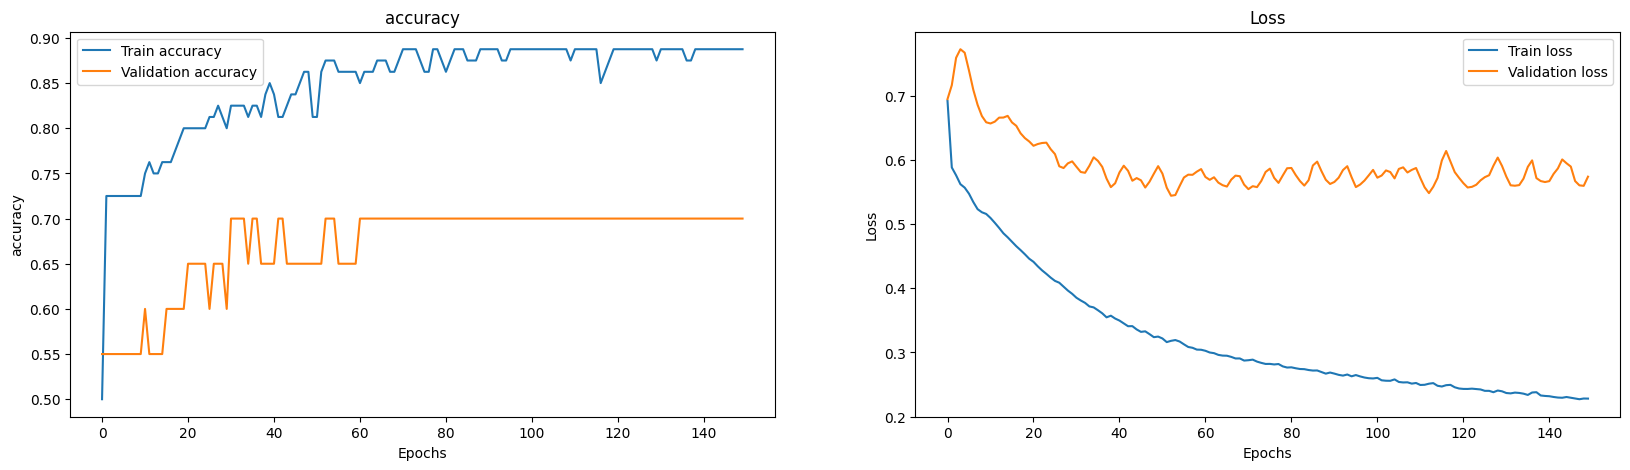

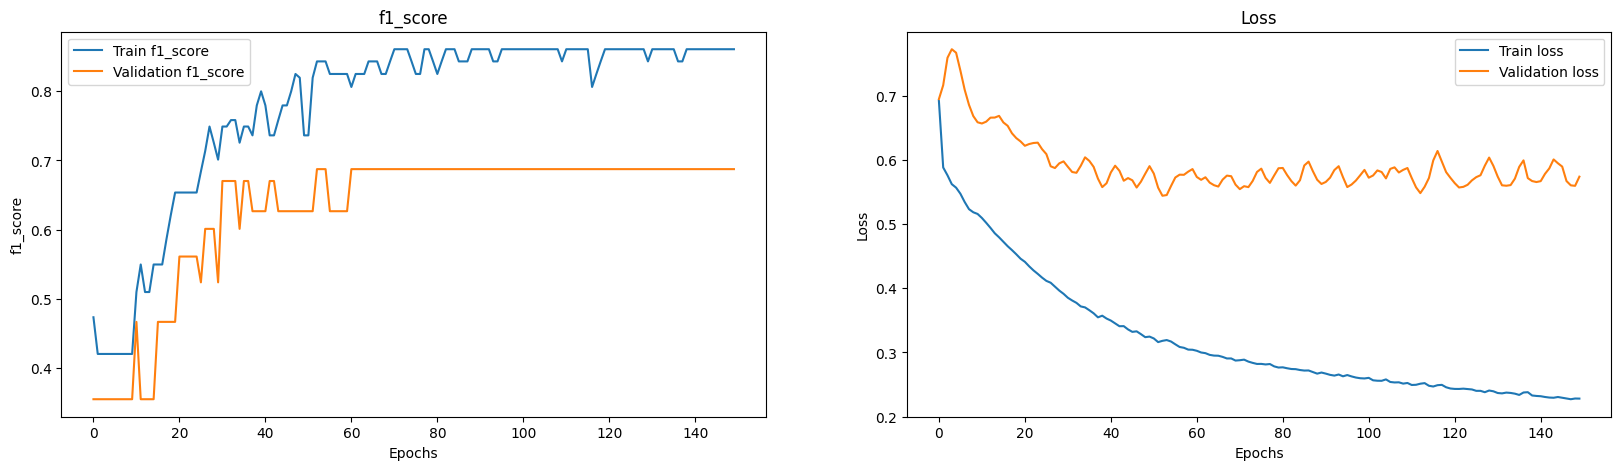

In [57]:
cnn_model1, cnn1_history = train_model(cnn_model1, "cnn_model1", X_train_CNN, y_train)

On complexifie l'architecture du modèle en y ajoutant plus de filtres et plus de couches de convolution.

In [58]:
input_shape = X_train_CNN.shape[1:]
input = layers.Input(shape=(input_shape))
x = layers.Conv1D(32, 3, padding="same", activation='relu')(input)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(64, 3, padding="same", activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 3, padding="same", activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(256, 3, padding="same", activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
cnn_model2 = models.Model(input, output)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 48, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 24, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 12, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,378 (2.25 MB)

 Trainable params: 589,378 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

[codecarbon INFO @ 22:46:04] [setup] RAM Tracking...
[codecarbon INFO @ 22:46:04] [setup] GPU Tracking...
[codecarbon INFO @ 22:46:04] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:46:04] [setup] CPU Tracking...
[codecarbon WARNING @ 22:46:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:46:06] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:46:06] >>> Tracker's metadata:
[codecarbon INFO @ 22:46:06]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:46:06]   Python version: 3.10.6
[codecarbon INFO @ 22:46:06]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:46:06]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:46:06]   CPU count: 16
[codecarbon INFO @ 22:46:06]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:46:06]   GPU count: 1
[codecarbon INFO @ 22:46:06]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU
[codecarbon INFO @ 22:46:21] Ene

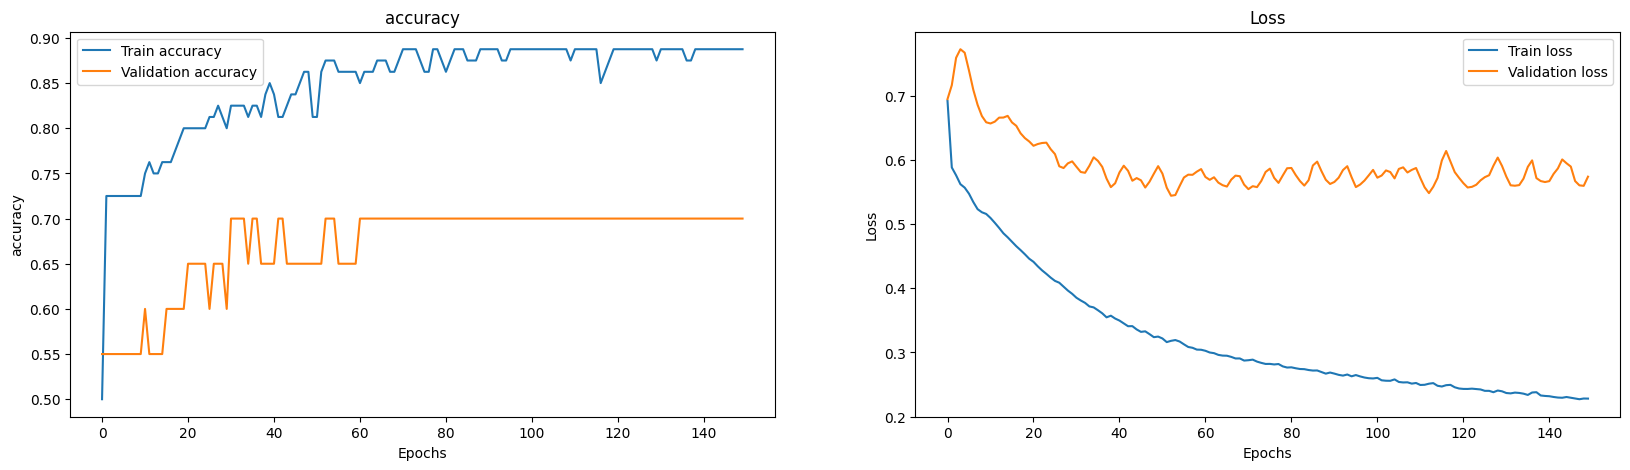

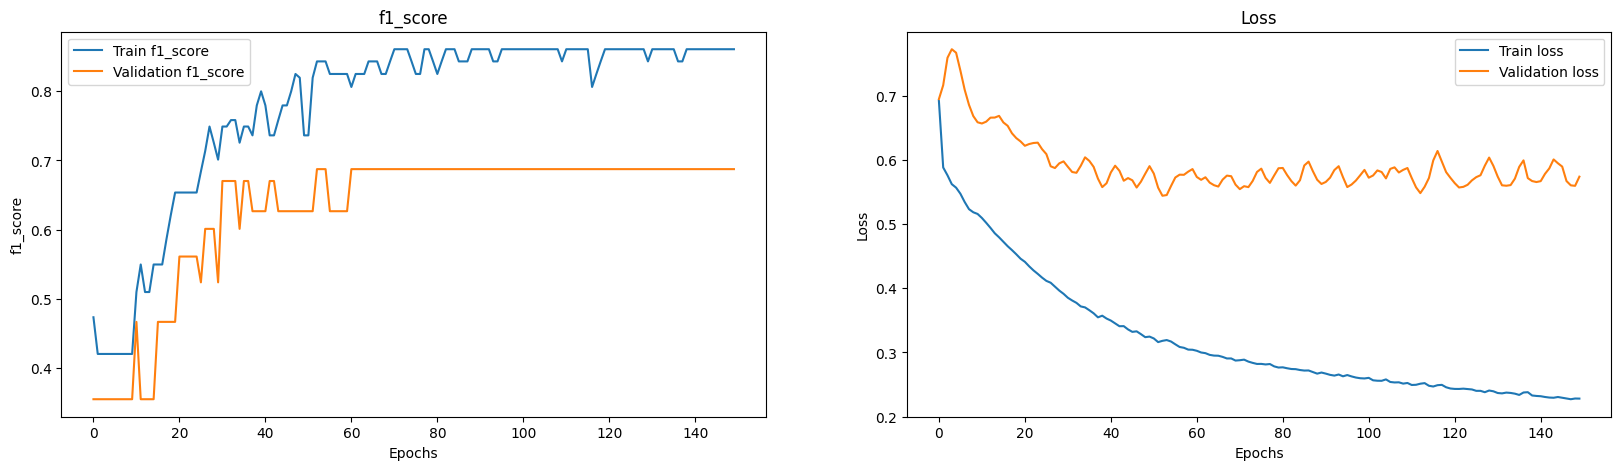

In [59]:
cnn_model2, cnn2_history = train_model(cnn_model2, "cnn_model2", X_train_CNN, y_train)

De la même manière, en complexifiant le modèle, celui-ci arrive mieux à généraliser.

On essaye un modèle en utilisant des couches de batch_normalization plutôt que du dropout

In [60]:
input_shape = X_train_CNN.shape[1:]
input = layers.Input(shape=(input_shape))
x = layers.Conv1D(32, 3, padding="same", activation='relu')(input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 3, padding="same", activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(128, 3, padding="same", activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(256, 3, padding="same", activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
cnn_model3 = models.Model(input, output)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 96, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 48, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 24, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 12, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,298 (2.26 MB)

 Trainable params: 590,338 (2.25 MB)

 Non-trainable params: 960 (3.75 KB)

[codecarbon INFO @ 22:46:32] [setup] RAM Tracking...
[codecarbon INFO @ 22:46:32] [setup] GPU Tracking...
[codecarbon INFO @ 22:46:32] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:46:32] [setup] CPU Tracking...
[codecarbon WARNING @ 22:46:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:46:34] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:46:34] >>> Tracker's metadata:
[codecarbon INFO @ 22:46:34]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:46:34]   Python version: 3.10.6
[codecarbon INFO @ 22:46:34]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:46:34]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:46:34]   CPU count: 16
[codecarbon INFO @ 22:46:34]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:46:34]   GPU count: 1
[codecarbon INFO @ 22:46:34]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU
[codecarbon INFO @ 22:46:49] Ene

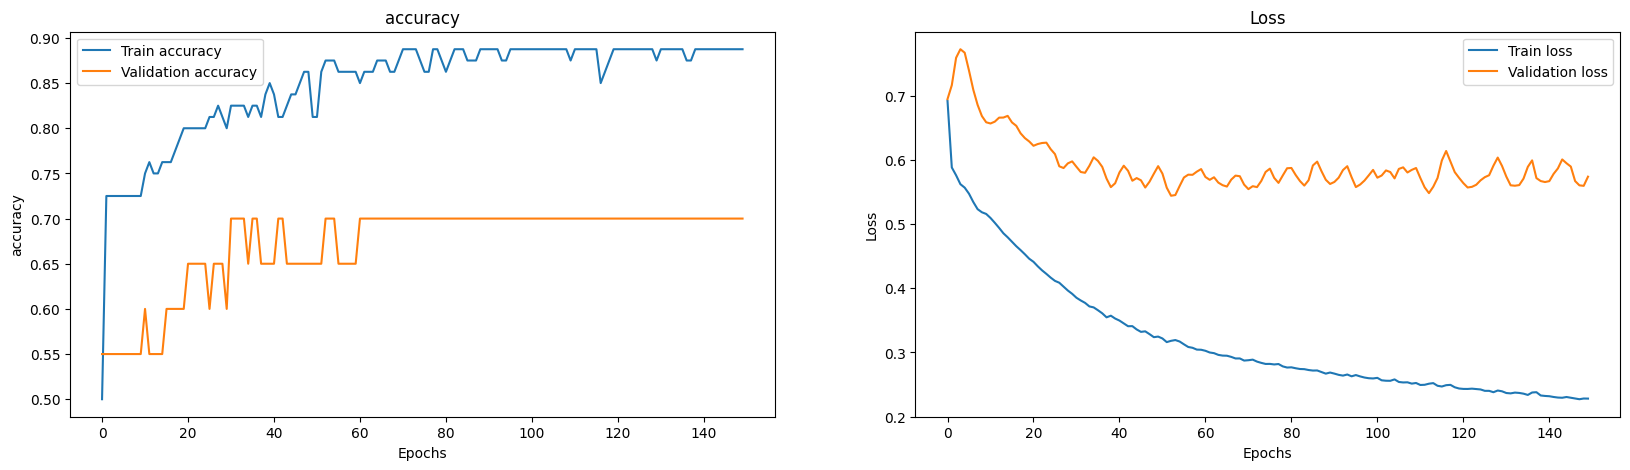

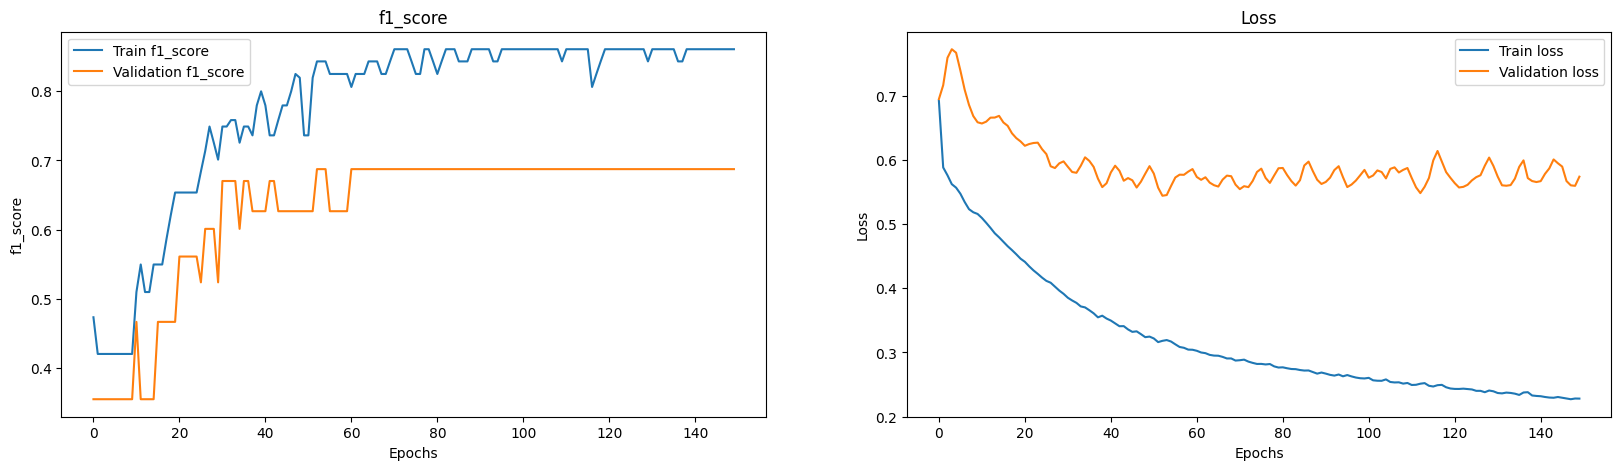

In [61]:
cnn_model3, cnn3_history = train_model(cnn_model3, "cnn_model3", X_train_CNN, y_train)

En utilisant des couches de batch_normalization, on se rend compte que le modèle surapprend.  
On suppose que c'est le cas car les couches de batch_normalization normalisent trop le jeu de données qui est assez "simple". C'est pour cette raison que par la suite, nous n'utiliserons que des couches de Dropout.

Dans chaque modèles de CNN, des couches de régularisation comme le Dropout ou le Batch_normalization sont utilisées pour régulariser les données, le rendre plus robuste face au surapprentissage. Qu'en est-il si l'on ne s'en sert pas ?

In [62]:
input_shape = X_train_CNN.shape[1:]
input = layers.Input(shape=(input_shape))
x = layers.Conv1D(8, 3, padding="same", activation='relu')(input) #on utilise padding="same" pour ne pas perdre d'informations 
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
cnn_model4 = models.Model(input, output)

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 96, 8)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 96, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,834 (97.01 KB)

 Trainable params: 24,818 (96.95 KB)

 Non-trainable params: 16 (64.00 B)

[codecarbon INFO @ 22:47:06] [setup] RAM Tracking...
[codecarbon INFO @ 22:47:06] [setup] GPU Tracking...
[codecarbon INFO @ 22:47:06] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:47:06] [setup] CPU Tracking...
[codecarbon WARNING @ 22:47:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:47:08] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:47:08] >>> Tracker's metadata:
[codecarbon INFO @ 22:47:08]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:47:08]   Python version: 3.10.6
[codecarbon INFO @ 22:47:08]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:47:08]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:47:08]   CPU count: 16
[codecarbon INFO @ 22:47:08]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:47:08]   GPU count: 1
[codecarbon INFO @ 22:47:08]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU
[codecarbon INFO @ 22:47:23] Ene

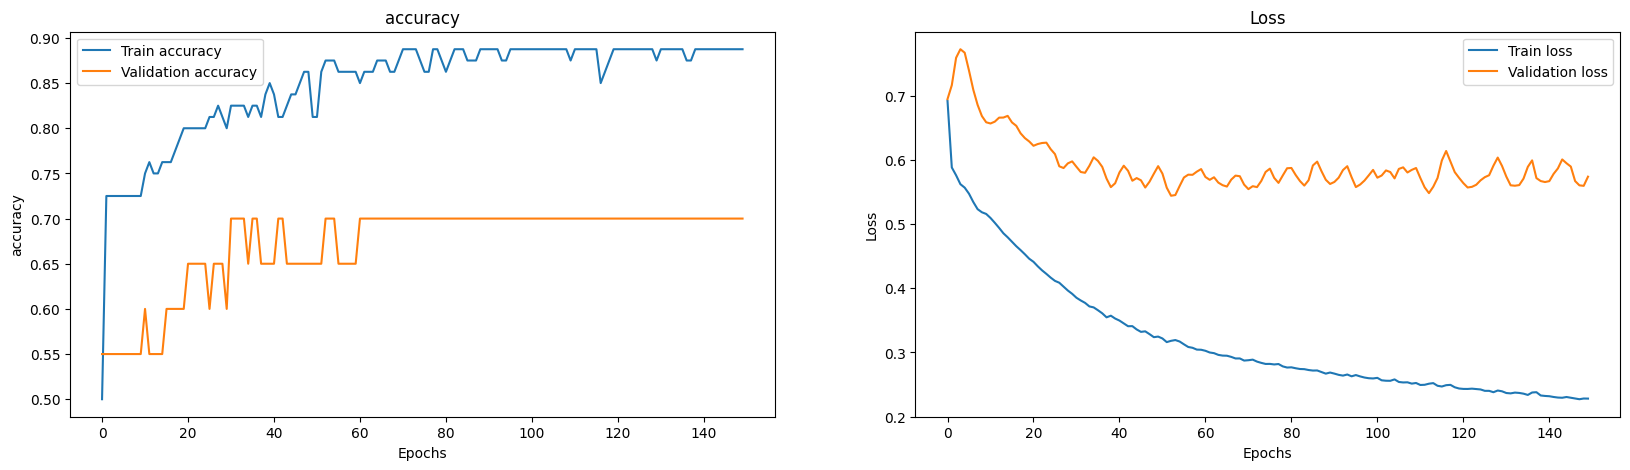

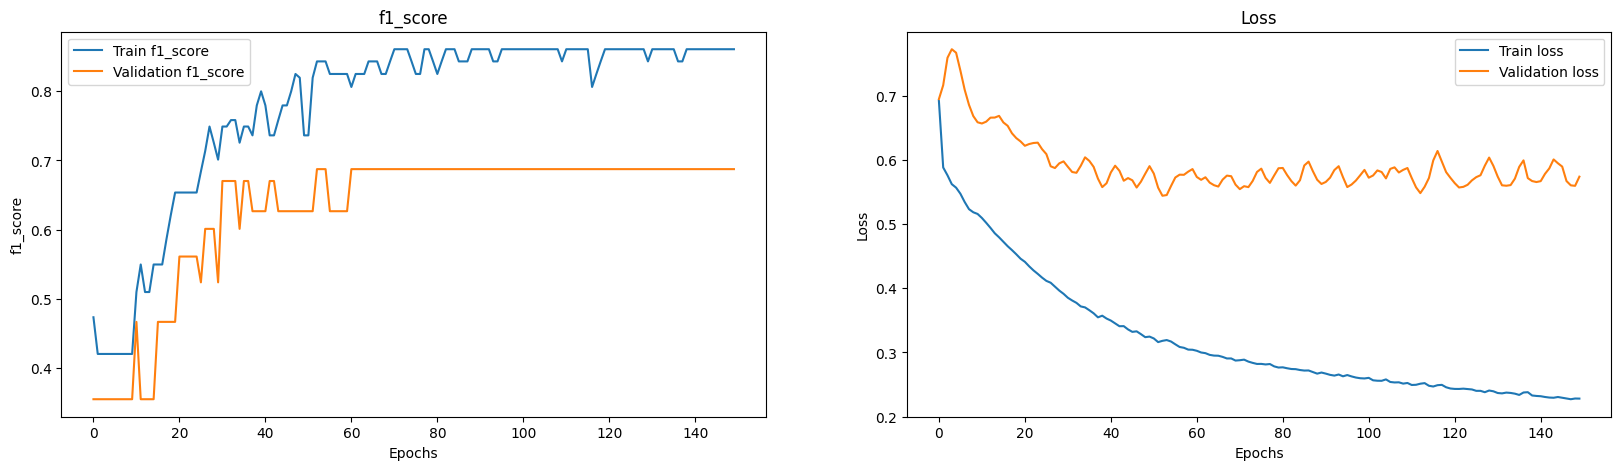

In [63]:
cnn_model4, cnn4_history = train_model(cnn_model4, "cnn_model4", X_train_CNN, y_train)

In [64]:
input_shape = X_train_CNN.shape[1:]
input = layers.Input(shape=(input_shape))
x = layers.Conv1D(32, 3, padding="same", activation='relu')(input)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 3, padding="same", activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(128, 3, padding="same", activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(256, 3, padding="same", activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
cnn_model5 = models.Model(input, output)

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 96, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 48, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 24, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 12, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,378 (2.25 MB)

 Trainable params: 589,378 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

[codecarbon INFO @ 22:47:31] [setup] RAM Tracking...
[codecarbon INFO @ 22:47:31] [setup] GPU Tracking...
[codecarbon INFO @ 22:47:31] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:47:31] [setup] CPU Tracking...
[codecarbon WARNING @ 22:47:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:47:33] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:47:33] >>> Tracker's metadata:
[codecarbon INFO @ 22:47:33]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:47:33]   Python version: 3.10.6
[codecarbon INFO @ 22:47:33]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:47:33]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:47:33]   CPU count: 16
[codecarbon INFO @ 22:47:33]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:47:33]   GPU count: 1
[codecarbon INFO @ 22:47:33]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU
[codecarbon INFO @ 22:47:48] Ene

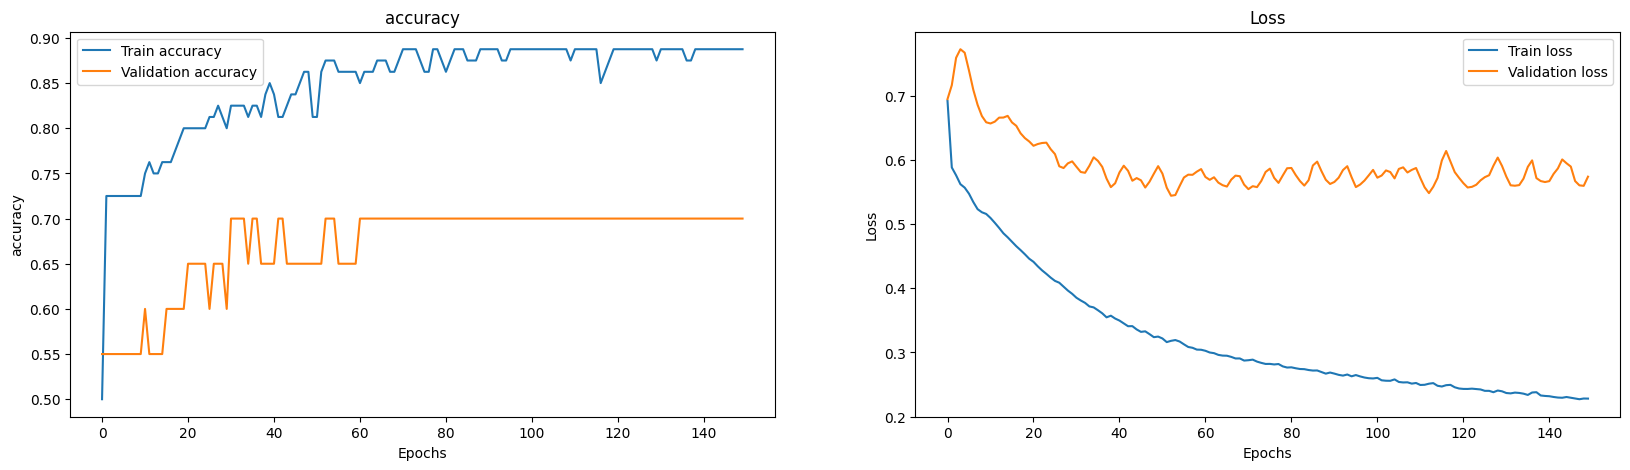

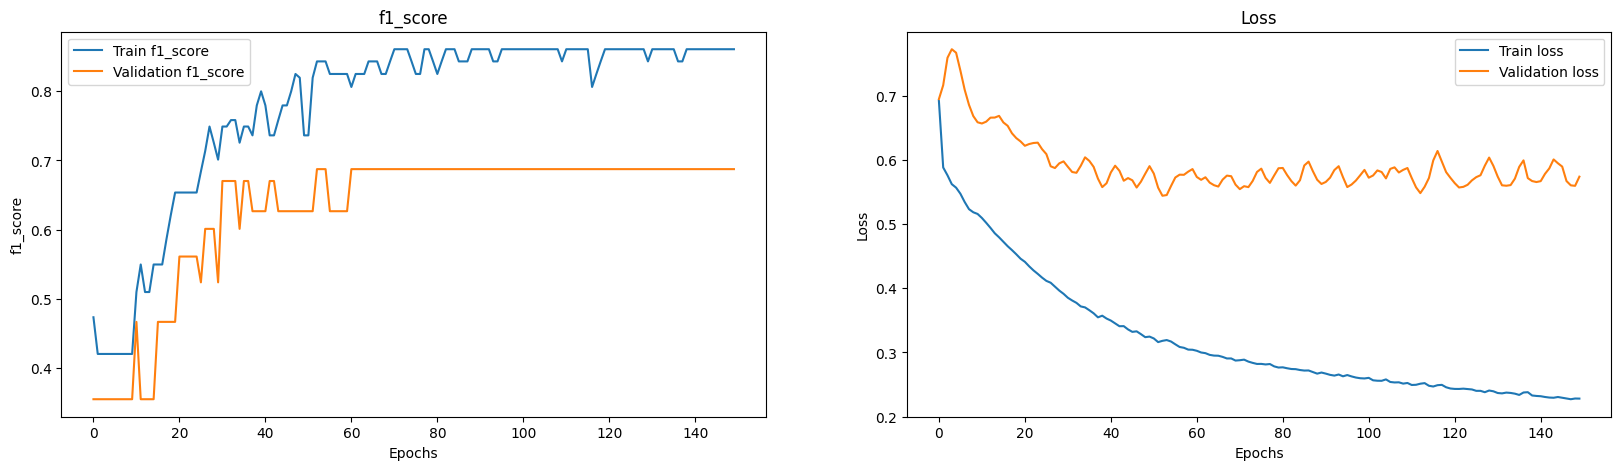

In [65]:
cnn_model5, cnn5_history = train_model(cnn_model5, "cnn_model5", X_train_CNN, y_train)

Les modèles semblent converger plus vite sans couches de régularisation.

## 4.2.2 Transfer learning

Plutôt que d'entraîner un modèle "from scratch", il peut être intéressant d'utiliser des modèles déjà pré-entrainés.  
Cela faciliterait grandement la phase d'aprentissage car ces modèles sont entraînés sur des banques de données immenses (+ de 10 millions d'images et 100 classes pour ImageNet).  
Même si ces modèles sont entraînés à reconnaître des classes complètement différentes de ce que l'on souhaite prédire, l'apprentissage par transfert reste intéressant dans la mesure où l'on récupère les poids des couches de convolutions, et ces couches sont entraînées à reconnaitre des pattern qui sont communes à toutes les images.  
Par exemple, les basses couches de convolutions sont utiles pour reconnaître les formes et bords d'objets.  

In [66]:
# vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(X_train.shape[1:]), weights="imagenet")

Dans le contexte de série temporelle, on pourrait se demander ce que cela peut donner, mais ce n'est pas aussi simple.  
En effet, la plupart des modèles pré-entrainés "connus" comme VGG16 sont entraînés sur des images 2D, tandis que les séries temporelles sont à une dimension.  
Nous avons cherché s'il existait des modèles pour traiter de la classification de séries temporelles, et nous sommes tombés sur un papier nommé " Transfer learning for time series classification ", publié par des scientifiques qui ne nous sont pas inconnus, à savoir : Hassan Ismail Fawaz, Germain Forestier, Jonathan Weber, Lhassane Idoumghar and Pierre-Alain Muller  
La tâche s'annonce trop compliquée, nous décidons d'abandonner cette piste.

## 4.3 RNN

On reshape l'entrée X sous la forme d'un vecteur de dimension 3 : nb_sambles, time_index, features. S'agissant de séries temporelles, on met features=1

In [67]:
X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [68]:
input = layers.Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))
x = layers.SimpleRNN(32, activation='relu')(input)
x = layers.Dense(16, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
rnn_model1 = models.Model(input, output)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,650 (6.45 KB)

 Trainable params: 1,650 (6.45 KB)

 Non-trainable params: 0 (0.00 B)

[codecarbon INFO @ 22:47:58] [setup] RAM Tracking...
[codecarbon INFO @ 22:47:58] [setup] GPU Tracking...
[codecarbon INFO @ 22:47:58] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:47:58] [setup] CPU Tracking...
[codecarbon WARNING @ 22:47:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:48:00] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:48:00] >>> Tracker's metadata:
[codecarbon INFO @ 22:48:00]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:48:00]   Python version: 3.10.6
[codecarbon INFO @ 22:48:00]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:48:00]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:48:00]   CPU count: 16
[codecarbon INFO @ 22:48:00]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:48:00]   GPU count: 1
[codecarbon INFO @ 22:48:00]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU
[codecarbon INFO @ 22:48:17] Ene

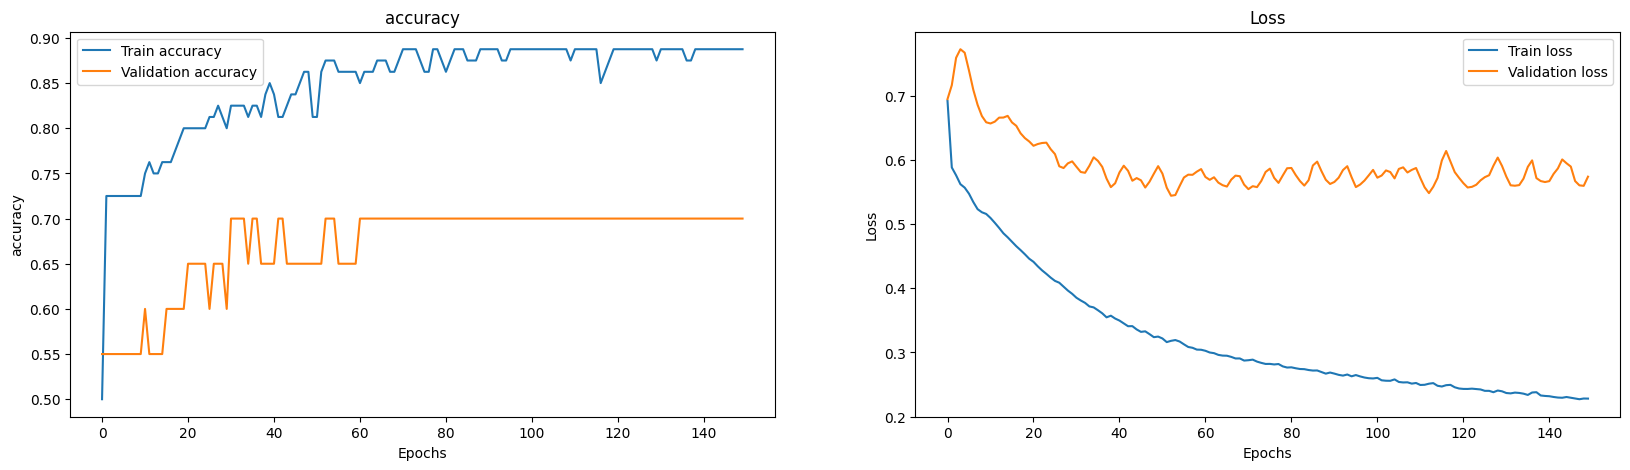

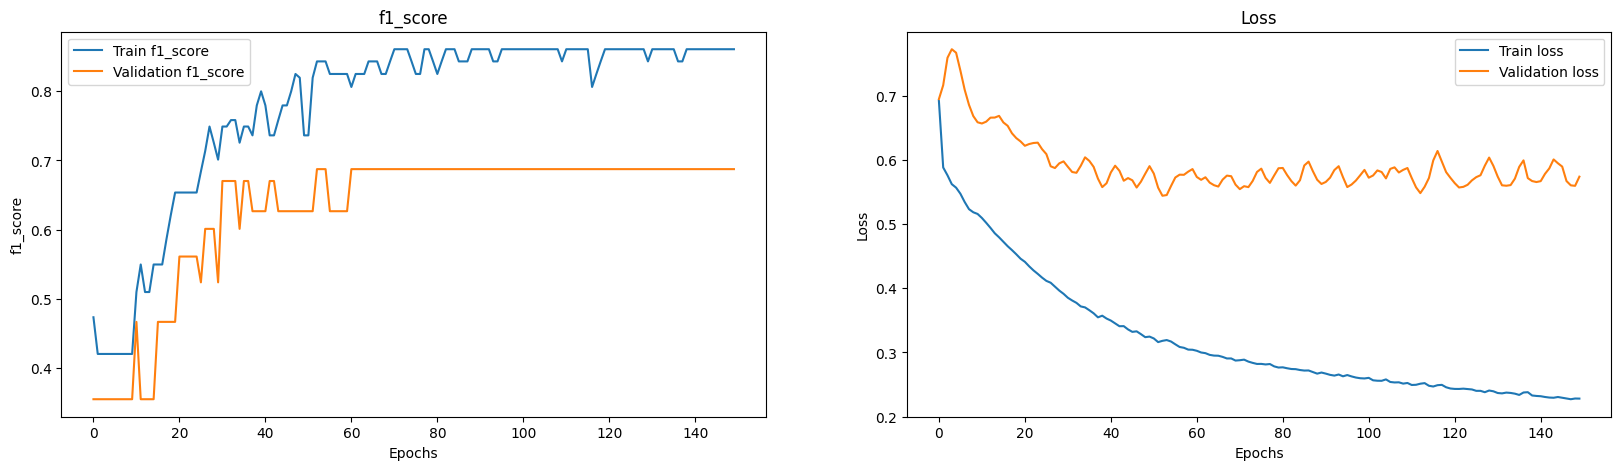

In [69]:
rnn_model1, rnn1_history = train_model(rnn_model1, "rnn_model1", X_train_rnn, y_train)

On complexifie le modèle.

In [70]:
input = layers.Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))
x = layers.SimpleRNN(64, activation='relu', return_sequences=True)(input)
x = layers.SimpleRNN(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(2, activation='softmax')(x)
rnn_model2 = models.Model(input, output)

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 96, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,682 (61.26 KB)

 Trainable params: 15,682 (61.26 KB)

 Non-trainable params: 0 (0.00 B)

[codecarbon INFO @ 22:48:25] [setup] RAM Tracking...
[codecarbon INFO @ 22:48:25] [setup] GPU Tracking...
[codecarbon INFO @ 22:48:25] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:48:25] [setup] CPU Tracking...
[codecarbon WARNING @ 22:48:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:48:27] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:48:27] >>> Tracker's metadata:
[codecarbon INFO @ 22:48:27]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 22:48:27]   Python version: 3.10.6
[codecarbon INFO @ 22:48:27]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 22:48:27]   Available RAM : 15.856 GB
[codecarbon INFO @ 22:48:27]   CPU count: 16
[codecarbon INFO @ 22:48:27]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:48:27]   GPU count: 1
[codecarbon INFO @ 22:48:27]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU
[codecarbon INFO @ 22:48:42] Ene

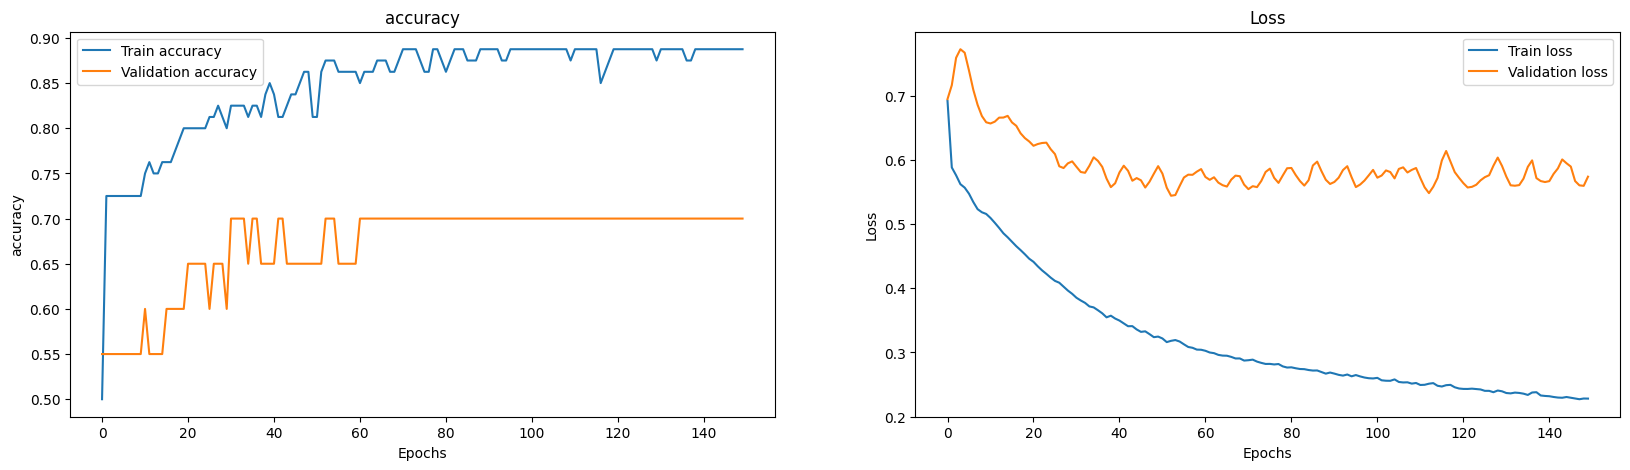

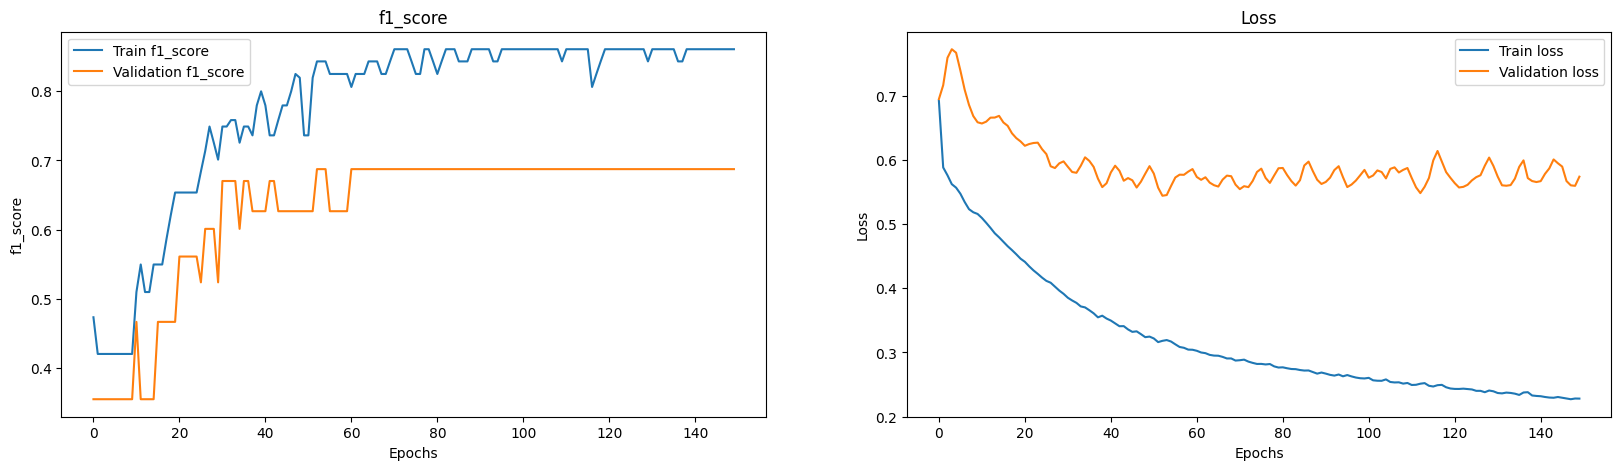

In [71]:
rnn_model2, rnn2_history = train_model(rnn_model2, "rnn_model2", X_train_rnn, y_train)

# 5. Évaluation des modèles

Il s'agit maintenant d'évaluer tous les modèles sur l'ensemble d'entraînement.  
Pour cela, il s'agira de comparer différentes métriques de validation : la justesse, la précision, le rappel et le F1-score.

$$ Justesse = \dfrac{Vrai\quad positif + Vrai \quad négatif}{Vrai\quad positif + Vrai \quad négatif + Faux\quad positif + Faux \quad négatif}$$
$$ Précision =  \dfrac{Vrai\quad positif}{Vrai\quad positif + Faux\quad négatif} $$
$$ Rappel =  \dfrac{Vrai\quad positif}{Vrai\quad positif + Faux\quad négatif} $$
$$ F1-Score =  \dfrac{2*Précision*Rappel}{Précision+Rappel} $$

 La justesse mesure le taux de bonnes prédictions. Cette métrique est pertinente si le jeu de donnée est équilibré.  
 La précision mesure le taux de bonnes prédictions parmi toutes les prédictions positives. Cette métrique est pertinente s'il y a beaucoup de faux positifs.  
 Le rappel mesure le taux de classes prédites positives parmi toutes les classes positives. Cette métrique est pertinente s'il y a beaucoup de faux négatifs.  
 Le F1-Score donne la moyenne harmonique de la précision et de la justesse. Cette métrique est pertinente si le jeu de donnée est fortement déséquilibré.

In [72]:
print("Evaluation du modèle MLP1", mlp_model1.evaluate(X_test, y_test))
print("Evaluation du modèle MLP2", mlp_model2.evaluate(X_test, y_test))
print("Evaluation du modèle MLP3", mlp_model3.evaluate(X_test, y_test))
print("Evaluation du modèle CNN1", cnn_model1.evaluate(X_test_CNN, y_test))
print("Evaluation du modèle CNN2", cnn_model2.evaluate(X_test_CNN, y_test))
print("Evaluation du modèle CNN3", cnn_model3.evaluate(X_test_CNN, y_test))
print("Evaluation du modèle CNN4", cnn_model4.evaluate(X_test_CNN, y_test))
print("Evaluation du modèle CNN5", cnn_model5.evaluate(X_test_CNN, y_test))
print("Evaluation du modèle RNN1", rnn_model1.evaluate(X_test_rnn, y_test))
print("Evaluation du modèle RNN2", rnn_model2.evaluate(X_test_rnn, y_test))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7847 - f1_score: 0.7690 - loss: 0.3881 
Evaluation du modèle MLP1 [0.3951420187950134, 0.7900000214576721, 0.7734872102737427]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8772 - f1_score: 0.8659 - loss: 0.6114 
Evaluation du modèle MLP2 [0.6481184959411621, 0.8700000047683716, 0.8580629825592041]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8772 - f1_score: 0.8659 - loss: 0.6114 
Evaluation du modèle MLP3 [0.6481184959411621, 0.8700000047683716, 0.8580629825592041]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8834 - f1_score: 0.8657 - loss: 0.3425 
Evaluation du modèle CNN1 [0.3865569233894348, 0.8700000047683716, 0.8493800163269043]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8619 - f1_score: 0.8477 - loss: 0.4313 
Evaluation du modèle CNN2 [0.45142197608947754, 0.8500000238418579, 0.8340523838996887]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7745 - f1_score: 0.7605 - loss: 0.4574 
Evaluation du modè

Néanmoins, la performance des modèles dépend de l'initialisation aléatoire des poids.  
Pour avoir des évaluations plus robustes, on va entraîner les modèles plusieurs fois puis calculer un score moyen avec un écart type.  

In [73]:
def train_model(model, model_name, X_train, y_train):
    epochs = 150
    batch_size = 32
    percentage_as_validation = 0.2
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=percentage_as_validation, verbose=False)
    return model, history

In [77]:
def run_model(model, X_train, y_train, X_test, model_name, iteration_number):
    accuracy = []
    f1_score = []
    for i in range(iteration_number):
        model, _ = train_model(model, "test", X_train, y_train)
        evaluation = model.evaluate(X_test, y_test, verbose=0)
        accuracy.append(evaluation[1])
        f1_score.append(evaluation[2])
    accuracy_mean = np.mean(accuracy)
    f1_score_mean = np.mean(f1_score)
    accuracy_std = np.std(accuracy)
    f1_score_std = np.std(f1_score)
    print(f"Modèle {model_name}, Accuracy moyenne {round(accuracy_mean, 4)} avec un écart type {round(accuracy_std, 4)}, F1-Score moyen {round(f1_score_mean, 4)} avec un écart type {round(f1_score_std, 4)} en lançant le modèle {iteration_number} fois")
    return accuracy_mean, f1_score_mean, accuracy_std, f1_score_std

In [78]:
import time
start = time.time()

run_model(mlp_model1, X_train, y_train, X_test, "mlp_model1", iteration_number=10)
run_model(mlp_model2, X_train, y_train, X_test, "mlp_model2", iteration_number=10)
run_model(mlp_model3, X_train, y_train, X_test, "mlp_model3", iteration_number=10)
run_model(cnn_model1, X_train_CNN, y_train, X_test_CNN, "cnn_model1", iteration_number=10)
run_model(cnn_model2, X_train_CNN, y_train, X_test_CNN, "cnn_model2", iteration_number=10)
run_model(cnn_model3, X_train_CNN, y_train, X_test_CNN, "cnn_model3", iteration_number=10)
run_model(cnn_model4, X_train_CNN, y_train, X_test_CNN, "cnn_model4", iteration_number=10)
run_model(cnn_model5, X_train_CNN, y_train, X_test_CNN, "cnn_model5", iteration_number=10)
run_model(rnn_model1, X_train_rnn, y_train, X_test_rnn, "rnn_model1", iteration_number=10)
run_model(rnn_model2, X_train_rnn, y_train, X_test_rnn, "rnn_model2", iteration_number=10)

end = time.time()

print("Temps d'exécution", end-start)

Modèle mlp_model1, Accuracy moyenne 0.851 avec un écart type 0.003, F1-Score moyen 0.8441 avec un écart type 0.0029 en lançant le modèle 10 fois
Modèle mlp_model2, Accuracy moyenne 0.905 avec un écart type 0.0143, F1-Score moyen 0.8981 avec un écart type 0.0145 en lançant le modèle 10 fois
Modèle mlp_model3, Accuracy moyenne 0.908 avec un écart type 0.0133, F1-Score moyen 0.9008 avec un écart type 0.0147 en lançant le modèle 10 fois
Modèle cnn_model1, Accuracy moyenne 0.891 avec un écart type 0.0158, F1-Score moyen 0.876 avec un écart type 0.0192 en lançant le modèle 10 fois
Modèle cnn_model2, Accuracy moyenne 0.889 avec un écart type 0.017, F1-Score moyen 0.8743 avec un écart type 0.0194 en lançant le modèle 10 fois
Modèle cnn_model3, Accuracy moyenne 0.9 avec un écart type 0.0, F1-Score moyen 0.8869 avec un écart type 0.0 en lançant le modèle 10 fois
Modèle cnn_model4, Accuracy moyenne 0.85 avec un écart type 0.0, F1-Score moyen 0.8341 avec un écart type 0.0 en lançant le modèle 10 f

In [81]:
print(f"Temps d'exécution {(end-start)/60} minutes")

Temps d'exécution 33.25383179585139 minutes


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

Comment lire une matrice de confusion ?

In [ ]:
import cv2

(-0.5, 646.5, 503.5, -0.5)

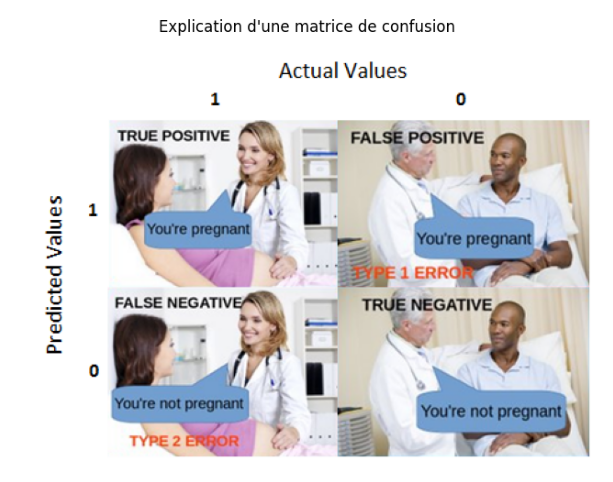

In [ ]:
plt.figure(figsize=(10, 6))
image = cv2.imread("images/cm.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")

In [ ]:
def plot_metrics(model, test_dataset, model_name):
    class_names = ["Anormal", "Normal"]
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    f1 = round(f1_score(y_true, y_pred), 3)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Prédiction")
    plt.ylabel("Vraie valeur")
    plt.title(f"Matrice de confusion pour {model_name}\nAccuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")
    plt.show()
    return [cm, accuracy, precision, recall, f1]

Pour les MLP

4/4 [==============================] - 0s 1ms/step


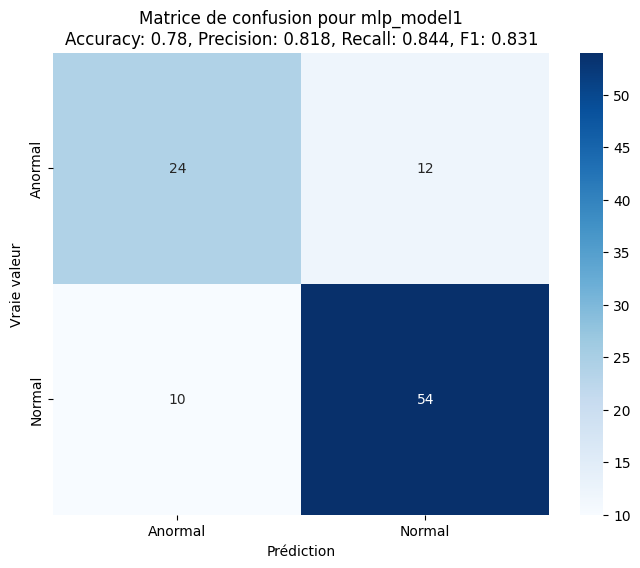

4/4 [==============================] - 0s 2ms/step


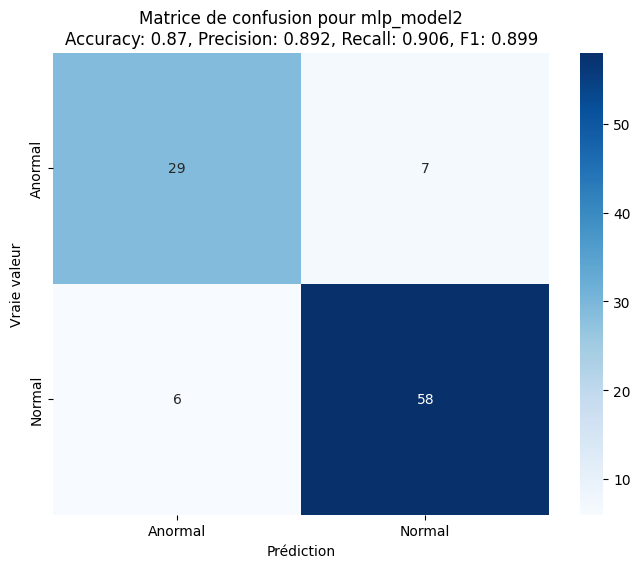

4/4 [==============================] - 0s 2ms/step


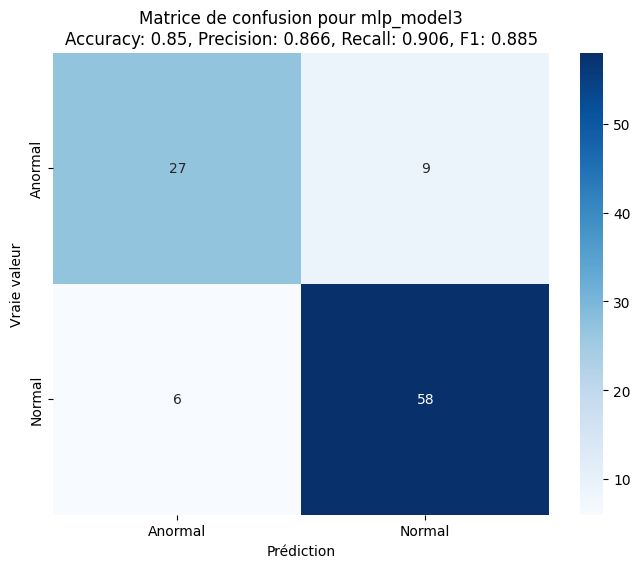

In [ ]:
mlp1_metrics = plot_metrics(mlp_model1, X_test, "mlp_model1")
mlp2_metrics = plot_metrics(mlp_model2, X_test, "mlp_model2")
mlp3_metrics = plot_metrics(mlp_model3, X_test, "mlp_model3");

Pour les CNN

4/4 [==============================] - 0s 2ms/step


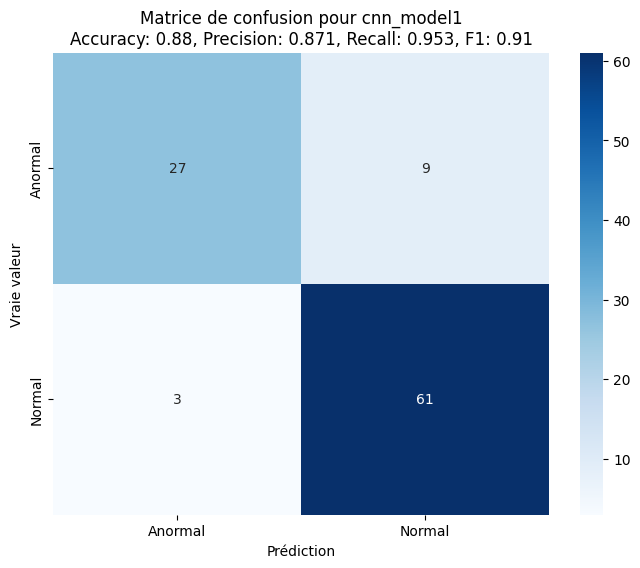

4/4 [==============================] - 0s 4ms/step


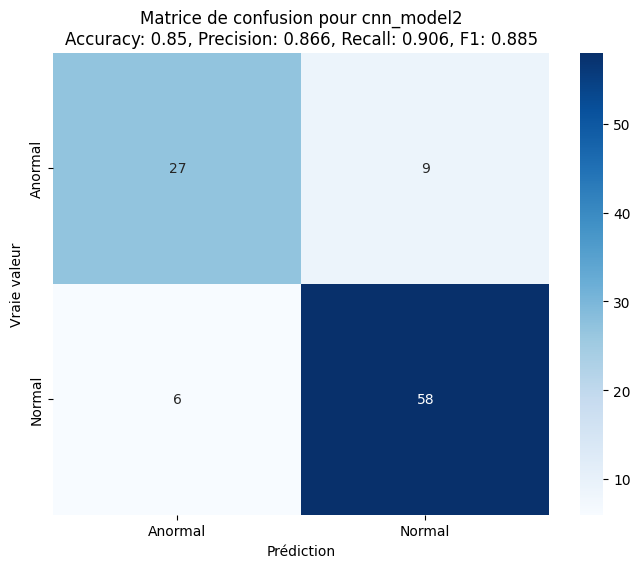

4/4 [==============================] - 0s 4ms/step


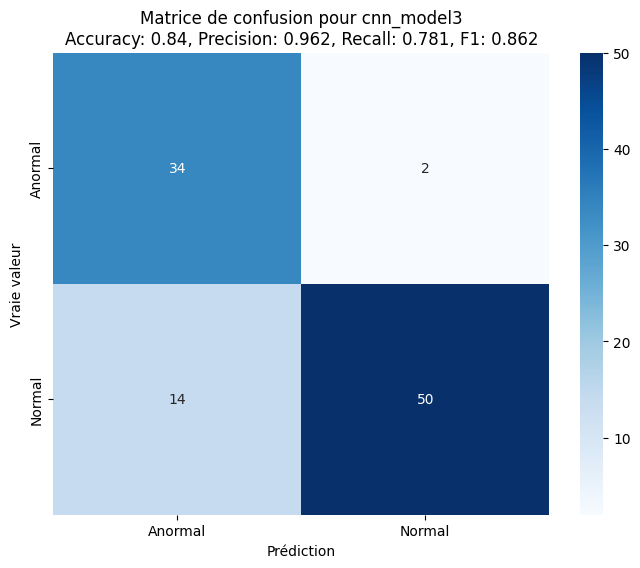

4/4 [==============================] - 0s 2ms/step


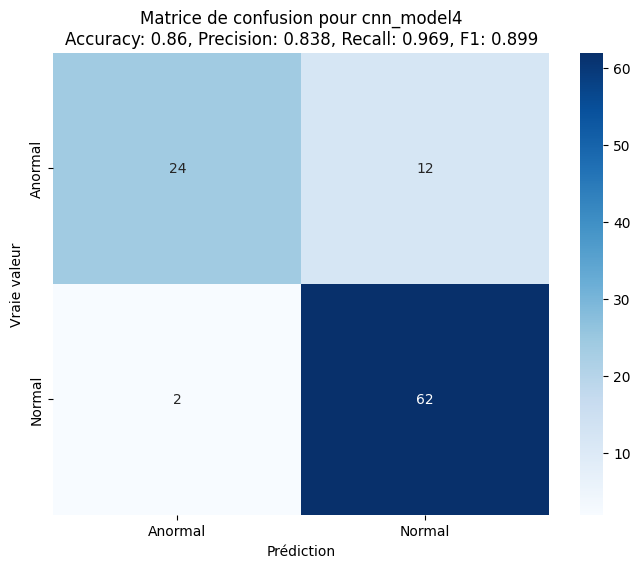

4/4 [==============================] - 0s 3ms/step


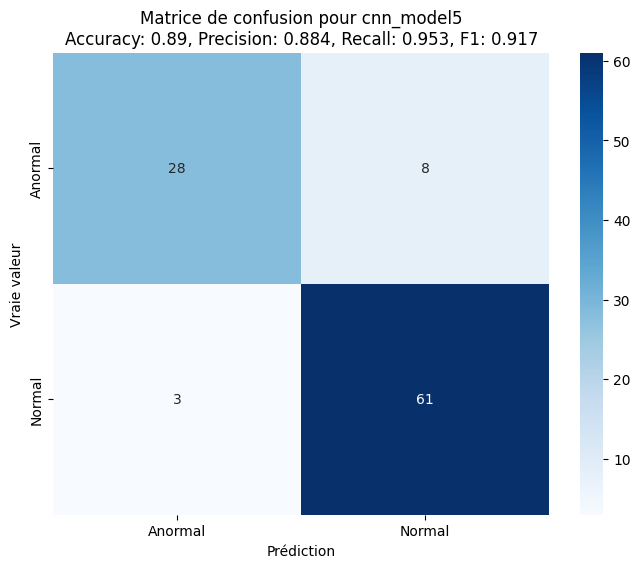

In [ ]:
cnn1_metrics = plot_metrics(cnn_model1, X_test_CNN, "cnn_model1")
cnn2_metrics = plot_metrics(cnn_model2, X_test_CNN, "cnn_model2")
cnn3_metrics = plot_metrics(cnn_model3, X_test_CNN, "cnn_model3")
cnn4_metrics = plot_metrics(cnn_model4, X_test_CNN, "cnn_model4")
cnn5_metrics = plot_metrics(cnn_model5, X_test_CNN, "cnn_model5");

Pour les RNN

4/4 [==============================] - 0s 3ms/step


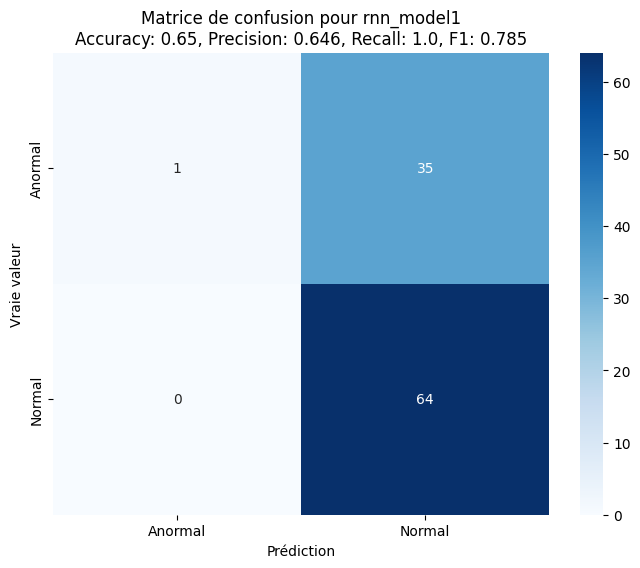

4/4 [==============================] - 0s 6ms/step


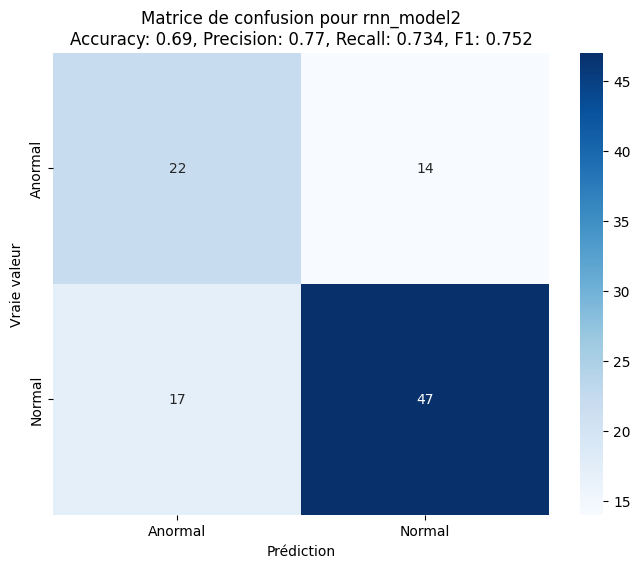

In [ ]:
rnn_metrics1 = plot_metrics(rnn_model1, X_test_rnn, "rnn_model1")
rnn_metrics2 = plot_metrics(rnn_model2, X_test_rnn, "rnn_model2");

On compare les performances des différents modèles

Text(0.5, 1.0, 'Score F1 des modèles')

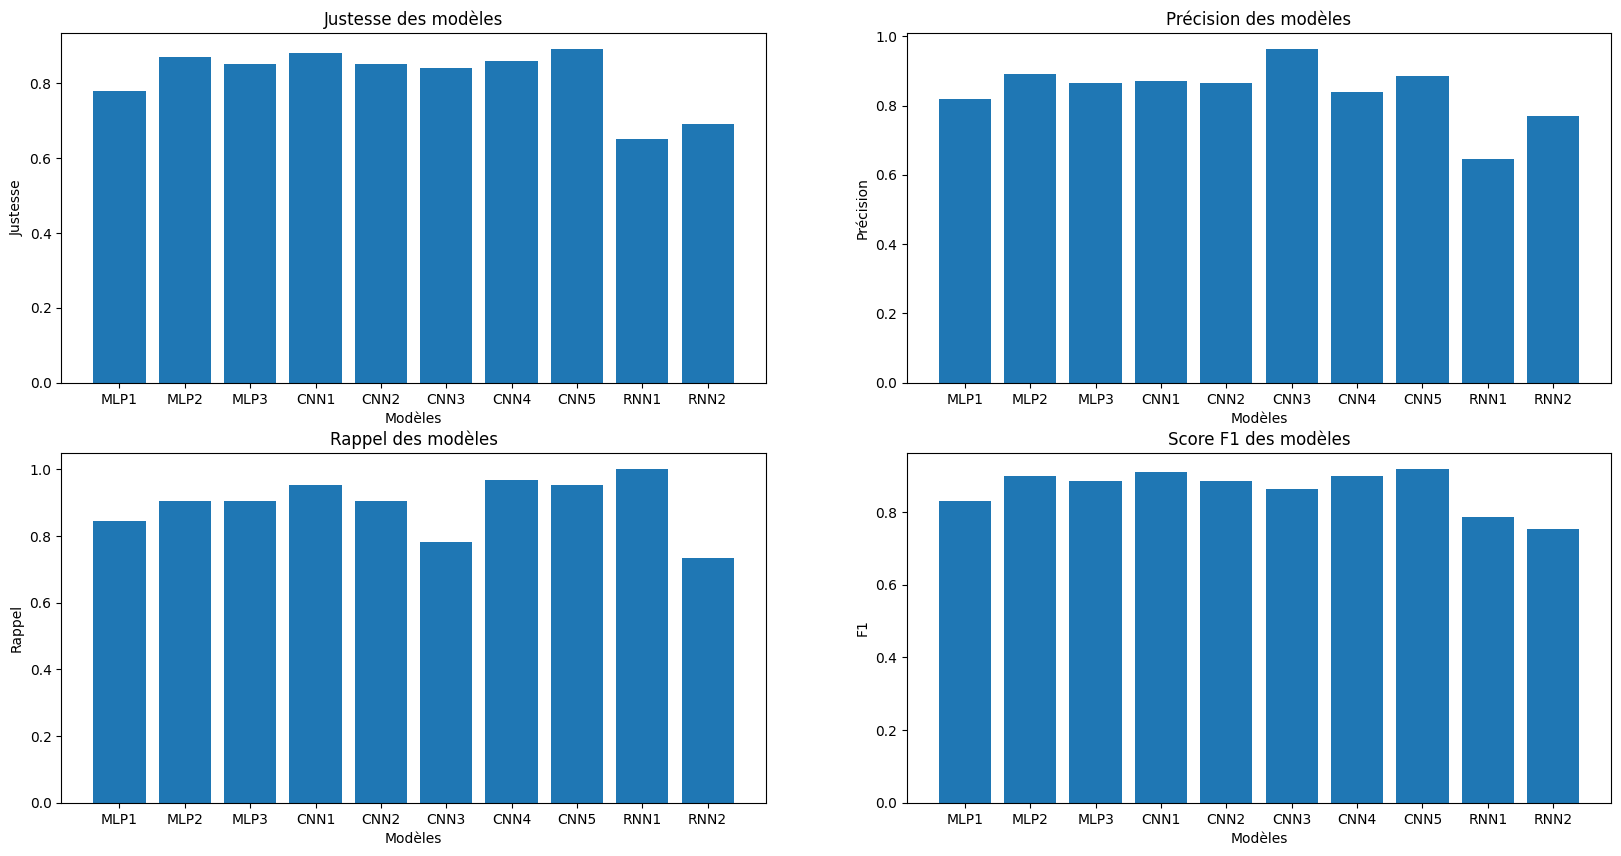

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
plt.bar(["MLP1", "MLP2", "MLP3", "CNN1", "CNN2", "CNN3", "CNN4", "CNN5", "RNN1", "RNN2"], [mlp1_metrics[1], mlp2_metrics[1], mlp3_metrics[1], cnn1_metrics[1], cnn2_metrics[1], cnn3_metrics[1], cnn4_metrics[1], cnn5_metrics[1], rnn_metrics1[1], rnn_metrics2[1]])
plt.xlabel("Modèles")
plt.ylabel("Justesse")
plt.title("Justesse des modèles")

plt.subplot(2,2,2)
plt.bar(["MLP1", "MLP2", "MLP3", "CNN1", "CNN2", "CNN3", "CNN4", "CNN5", "RNN1", "RNN2"], [mlp1_metrics[2], mlp2_metrics[2], mlp3_metrics[2], cnn1_metrics[2], cnn2_metrics[2], cnn3_metrics[2], cnn4_metrics[2], cnn5_metrics[2], rnn_metrics1[2], rnn_metrics2[2]])
plt.xlabel("Modèles")
plt.ylabel("Précision")
plt.title("Précision des modèles")

plt.subplot(2,2,3)
plt.bar(["MLP1", "MLP2", "MLP3", "CNN1", "CNN2", "CNN3", "CNN4", "CNN5", "RNN1", "RNN2"], [mlp1_metrics[3], mlp2_metrics[3], mlp3_metrics[3], cnn1_metrics[3], cnn2_metrics[3], cnn3_metrics[3], cnn4_metrics[3], cnn5_metrics[3], rnn_metrics1[3], rnn_metrics2[3]])
plt.xlabel("Modèles")
plt.ylabel("Rappel")
plt.title("Rappel des modèles")

plt.subplot(2,2,4)
plt.bar(["MLP1", "MLP2", "MLP3", "CNN1", "CNN2", "CNN3", "CNN4", "CNN5", "RNN1", "RNN2"], [mlp1_metrics[4], mlp2_metrics[4], mlp3_metrics[4], cnn1_metrics[4], cnn2_metrics[4], cnn3_metrics[4], cnn4_metrics[4], cnn5_metrics[4], rnn_metrics1[4], rnn_metrics2[4]])
plt.xlabel("Modèles")
plt.ylabel("F1")
plt.title("Score F1 des modèles")

Les classes étant déséquilibrées, il ne s'agit pas seulement de regarder la justesse. Par exemple, si l'on a 999 cas positifs et 1 cas négatifs, et que le modèle classifie tous les cas comme étant positifs, la justesse sera de 99%, mais le modèle ne sera pas forcément bon pour autant.  
Cela dépendra surtout de ce que l'on souhaite classifier. Dans le secteur bancaire par exemple dans la détection de fraude, les cas frauduleux sont rares mais non négligeables.  
Les classes étant déséquilibrées dans notre cas, la métrique F1-Score est à priori la plus pertinente.  

Text(0.5, 1.0, 'F1-Score des modèles')

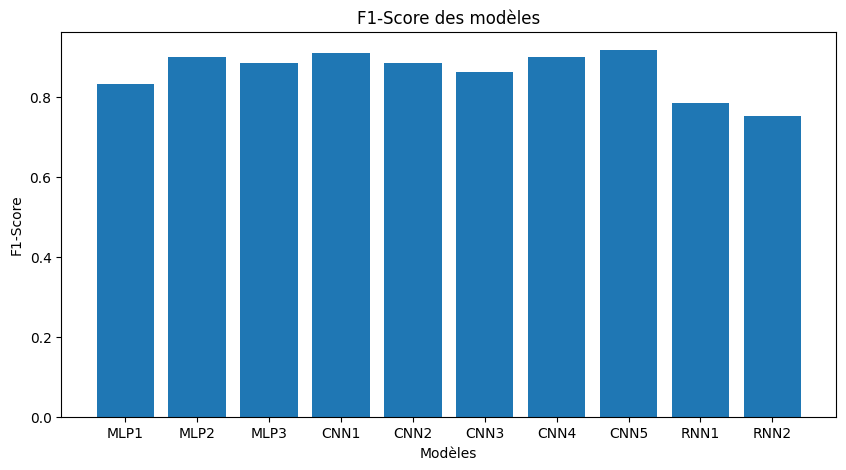

In [ ]:
#bar plot the accuracy in ascending order
plt.figure(figsize=(10, 5))
plt.bar(["MLP1", "MLP2", "MLP3", "CNN1", "CNN2", "CNN3", "CNN4", "CNN5", "RNN1", "RNN2"], [mlp1_metrics[4], mlp2_metrics[4], mlp3_metrics[4], cnn1_metrics[4], cnn2_metrics[4], cnn3_metrics[4], cnn4_metrics[4], cnn5_metrics[4], rnn_metrics1[4], rnn_metrics2[4]])
plt.xlabel("Modèles")
plt.ylabel("F1-Score")
plt.title("F1-Score des modèles")


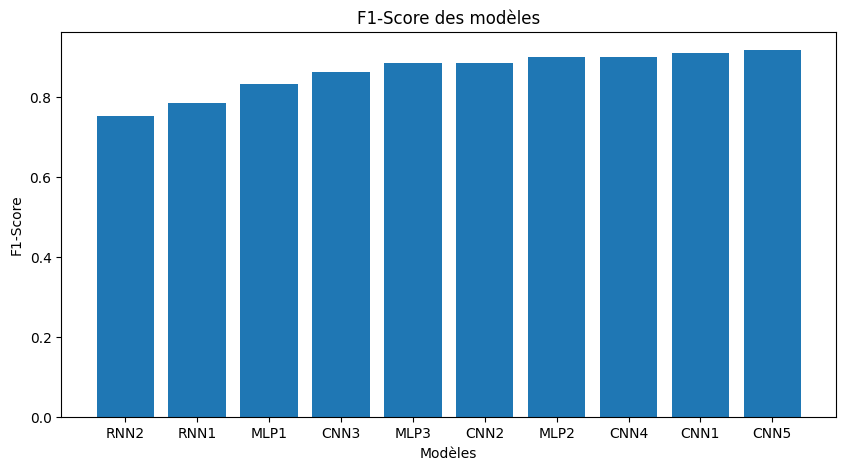

In [ ]:
model_names = ["MLP1", "MLP2", "MLP3", "CNN1", "CNN2", "CNN3", "CNN4", "CNN5", "RNN1", "RNN2"]
f1_score_values = [mlp1_metrics[4], mlp2_metrics[4], mlp3_metrics[4], cnn1_metrics[4], cnn2_metrics[4], cnn3_metrics[4], cnn4_metrics[4], cnn5_metrics[4], rnn_metrics1[4], rnn_metrics2[4]]

sorted_indices = np.argsort(f1_score_values)
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_f1 = [f1_score_values[i] for i in sorted_indices]

plt.figure(figsize=(10, 5))
plt.bar(sorted_model_names, sorted_f1)
plt.xlabel("Modèles")
plt.ylabel("F1-Score")
plt.title("F1-Score des modèles")
plt.show()

Qu'en est-il des temps d'entraînements et consommations ?

In [83]:
df_emissions = pd.read_csv('emissions/emissions.csv')
df_emissions.head()

timestamp    project_name                                run_id  \
0  2024-06-03T22:43:20      mlp_model1  92fa6860-11f6-43c1-8196-c1a01193f61d   
1  2024-06-03T22:43:41      mlp_model2  3f317690-7d6b-4a94-8cea-035b82613fa8   
2  2024-06-03T22:44:07  mlp_model_test  753643d4-4886-4ab9-9962-57c3ea011b0d   
3  2024-06-03T22:44:33  mlp_model_test  0baedad0-07c9-4bf5-aa36-ff46ebb260a8   
4  2024-06-03T22:44:58  mlp_model_test  1f1a4ace-2994-4521-b4f3-5abdc1b259e9   

    duration  emissions  emissions_rate  cpu_power  gpu_power  ram_power  \
0  19.171617   0.000017    8.957714e-07       27.0  14.926573   5.945822   
1  18.016876   0.000016    8.970011e-07       27.0  17.975904   5.945822   
2  21.196007   0.000019    9.060234e-07       27.0  15.816787   5.945822   
3  22.135011   0.000020    8.837861e-07       27.0  15.189901   5.945822   
4  21.450191   0.000019    9.022096e-07       27.0  16.075707   5.945822   

   cpu_energy  ...  cpu_count                               cpu_model  \
0    0.000144  ...         16  AMD Ryzen 7 5800H with Radeon Graphics   
1    0.000135  ...         16  AMD Ryzen 7 5800H with Radeon Graphics   
2    0.000159  ...         16  AMD Ryzen 7 5800H with Radeon Graphics   
3    0.000166  ...         16  AMD Ryzen 7 5800H with Radeon Graphics   
4    0.000161  ...         16  AMD Ryzen 7 5800H with Radeon Graphics   

   gpu_count                               gpu_model longitude latitude  \
0          1  1 x NVIDIA GeForce RTX 3060 Laptop GPU    2.4075  48.8323   
1          1  1 x NVIDIA GeForce RTX 3060 Laptop GPU    2.4075  48.8323   
2          1  1 x NVIDIA GeForce RTX 3060 Laptop GPU    2.4075  48.8323   
3          1  1 x NVIDIA GeForce RTX 3060 Laptop GPU    2.4075  48.8323   
4          1  1 x NVIDIA GeForce RTX 3060 Laptop GPU    2.4075  48.8323   

   ram_total_size  tracking_mode on_cloud  pue  
0       15.855526        machine        N  1.0  
1       15.855526        machine        N  1.0  
2       15.855526        machine        N  1.0  
3       15.855526        machine        N  1.0  
4       15.855526        machine        N  1.0  

[5 rows x 31 columns]

Bien qu'une GPU soit présente, les calculs sont effectués sur CPU car TensorFlow n'utilise pas les GPU sans CUDA et cuDNN

In [ ]:
import tensorflow as tf

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

On voit bien que Tensorflow détecte le CPU mais pas le GPU. Les calculs sont alors effectués sur CPU.

In [84]:
df_emissions.describe()

duration     emissions  emissions_rate  cpu_power  gpu_power  \
count  13.000000  1.300000e+01    1.300000e+01       13.0  13.000000   
mean   22.593426  1.902968e-05    8.290227e-07       27.0  15.425765   
std     4.213890  6.547218e-06    2.396223e-07        0.0   0.984308   
min    17.927804  5.709374e-07    3.184647e-08       27.0  14.207181   
25%    20.514297  1.850760e-05    8.876749e-07       27.0  14.836351   
50%    21.450191  1.935257e-05    8.957714e-07       27.0  15.434066   
75%    23.560882  2.122435e-05    9.008300e-07       27.0  15.847827   
max    31.972839  2.838149e-05    9.060234e-07       27.0  17.975904   

       ram_power  cpu_energy  gpu_energy  ram_energy  energy_consumed  \
count  13.000000   13.000000   13.000000   13.000000        13.000000   
mean    5.945822    0.000169    0.000094    0.000037         0.000300   
std     0.000000    0.000032    0.000016    0.000007         0.000055   
min     5.945822    0.000134    0.000075    0.000030         0.000240   
25%     5.945822    0.000154    0.000087    0.000034         0.000275   
50%     5.945822    0.000161    0.000088    0.000035         0.000287   
75%     5.945822    0.000177    0.000099    0.000039         0.000315   
max     5.945822    0.000240    0.000129    0.000053         0.000421   

       cloud_provider  cloud_region  cpu_count  gpu_count  longitude  \
count             0.0           0.0       13.0       13.0  13.000000   
mean              NaN           NaN       16.0        1.0  -3.254615   
std               NaN           NaN        0.0        0.0  20.415047   
min               NaN           NaN       16.0        1.0 -71.200000   
25%               NaN           NaN       16.0        1.0   2.407500   
50%               NaN           NaN       16.0        1.0   2.407500   
75%               NaN           NaN       16.0        1.0   2.407500   
max               NaN           NaN       16.0        1.0   2.407500   

        latitude  ram_total_size   pue  
count  13.000000       13.000000  13.0  
mean   48.675969       15.855526   1.0  
std     0.563659        0.000000   0.0  
min    46.800000       15.855526   1.0  
25%    48.832300       15.855526   1.0  
50%    48.832300       15.855526   1.0  
75%    48.832300       15.855526   1.0  
max    48.832300       15.855526   1.0

Text(0.5, 1.0, 'Énergie consommée par les modèles')

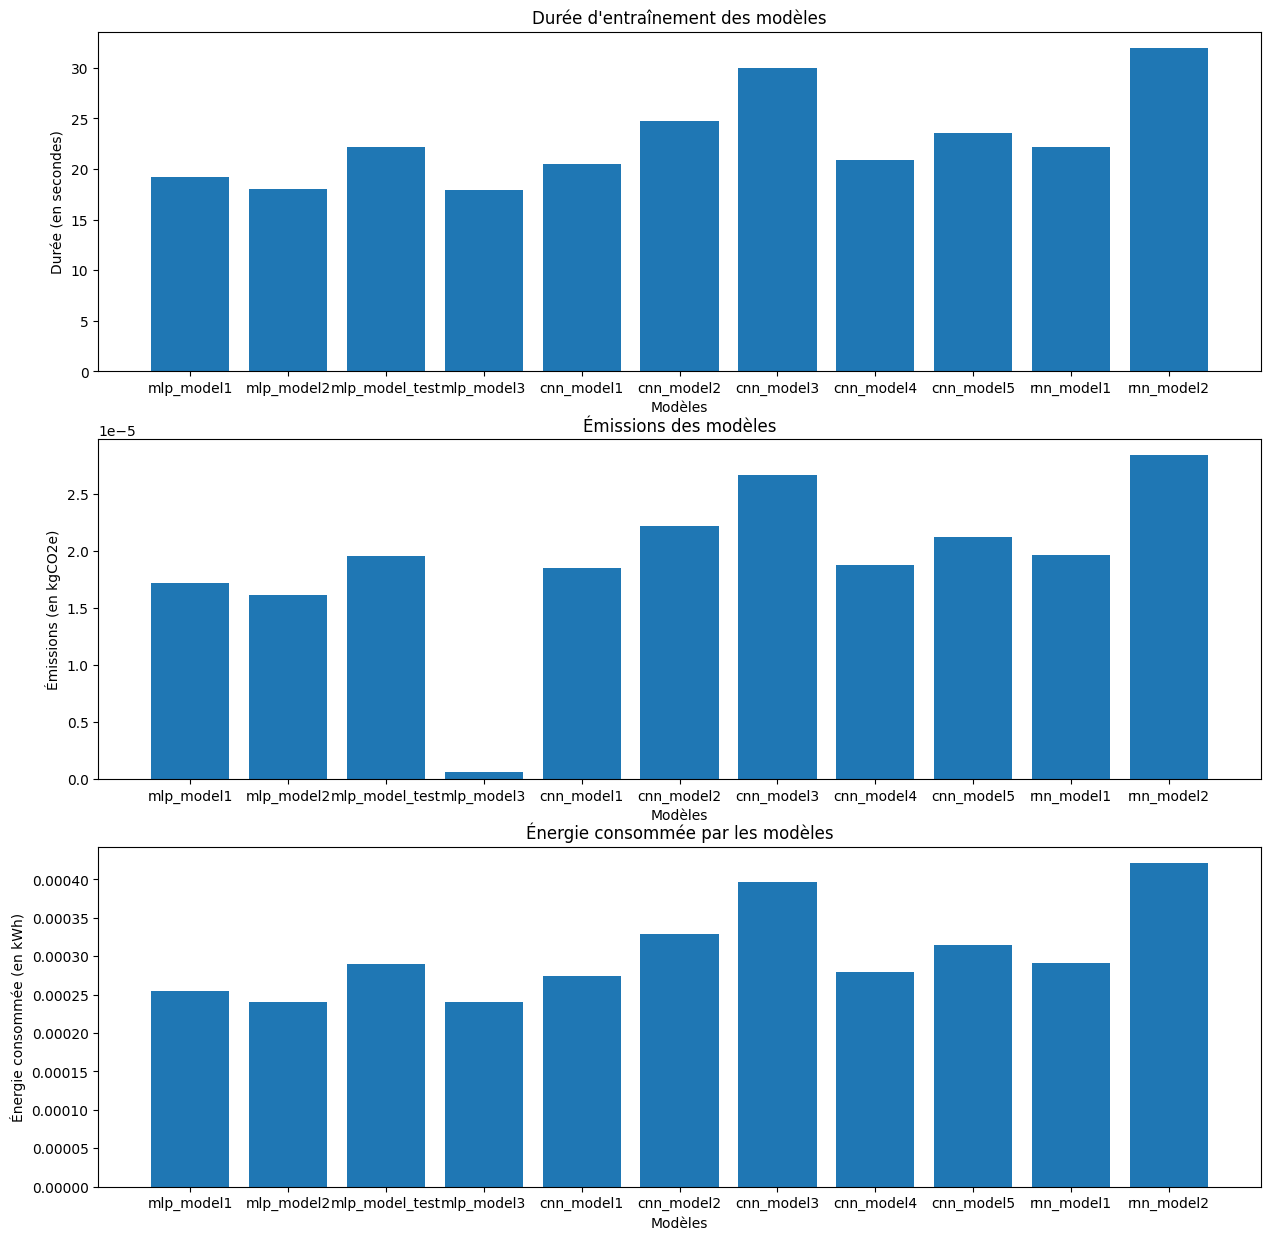

In [85]:
plt.figure(figsize=(15, 15))
plt.subplot(3,1,1)
plt.bar(df_emissions['project_name'], df_emissions['duration'])
plt.xlabel("Modèles")
plt.ylabel("Durée (en secondes)")
plt.title("Durée d'entraînement des modèles")

plt.subplot(3,1,2)
plt.bar(df_emissions['project_name'], df_emissions['emissions'])
plt.xlabel("Modèles")
plt.ylabel("Émissions (en kgCO2e)")
plt.title("Émissions des modèles")

plt.subplot(3,1,3)
plt.bar(df_emissions['project_name'], df_emissions['energy_consumed'])
plt.xlabel("Modèles")
plt.ylabel("Énergie consommée (en kWh)")
plt.title("Énergie consommée par les modèles")


On remarque tout de suite que le modèle RNN2 consomme bien plus de ressources que tous les autres modèles, mais n'est pas pour autant meilleur que les autres.  
Tous les modèles avoisinent quasimment les 80% de précision sur l'ensemble d'entraînement. On peut alors considérer le modèle CNN5 comme étant le meilleur modèle parmi tout ceux testés.  
En effet, sa consommation est dans la moyenne, et ses métriques sont les plus élevées.

# 6. Conclusion

Les modèles les plus complexes ne sont pas forcément les " meilleurs ".  
Bien que certains modèles plus complexes ont de meilleurs résultats, l'apprentissage de ceux-ci nécessitent plus de ressources pour atteindre une performance assez similaire à un modèle moins complexe.  
Dans ce cas, de ce point de vue, il serait plus judicieux d'opter pour le modèle moins complexe car celui-ci aurait une empreinte carbone moindre.

De plus, il faut regarder au-delà des chiffres de métrique.  
Dans le contexte d'analyse de signaux ECG, il est par exemple moins grave de prédire un cas normal comme étant anormal plutôt que l'inverse.  
Dans ce cas, ces modèles pourraient pousser le docteur à effectuer plus d'analyses sur le patient pour se rendre compte que le patient n'a rien, alors que dans le cas inverse, cela pourrait entraîner des répercussions grave sur le patient.

On peut comparer les cnn_model1 et cnn_model3. 

4/4 [==============================] - 0s 3ms/step


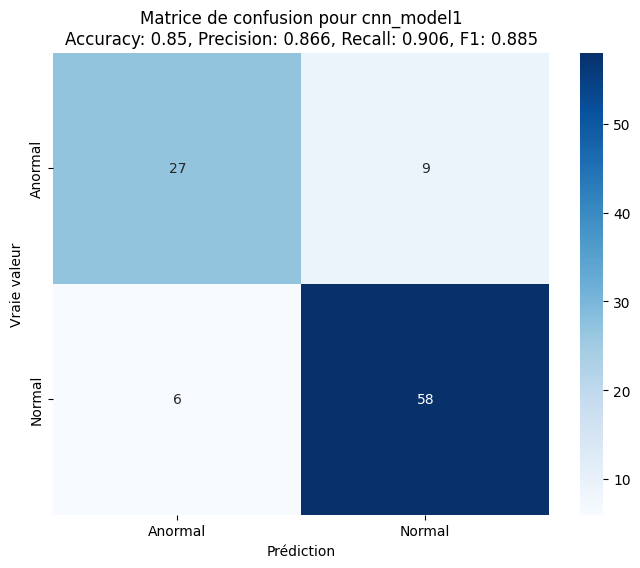

4/4 [==============================] - 0s 3ms/step


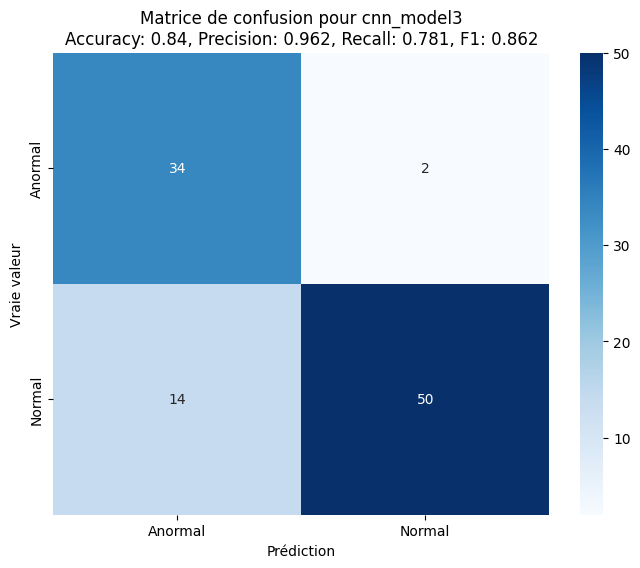

In [ ]:
cnn1_metrics = plot_metrics(cnn_model2, X_test_CNN, "cnn_model1")
cnn3_metrics = plot_metrics(cnn_model3, X_test_CNN, "cnn_model3")

Le modèle cnn_model3 se ne se trompe quasimment pas sur les cas anormaux mais se trompe plus sur les cas normaux tandis que le modèle cnn_model1 ne se trompe pas beaucoup sur les 2 cas.  
Dans notre contexte, le cnn_model3 serait plus intéressant.